This notebook calculates the Mahalanobis distance between points on a pca. 
I will document more about what Mahalanobis distance is and how it is calculated in this notebook.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.spatial.distance import mahalanobis
from scipy.stats import f_oneway as anova
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# set the path to the data
custom_aggregated_data_pca_path = pathlib.Path(
    "../../data/6.analysis_results/custom_aggregated_pca.parquet"
).resolve(strict=True)

# read the data
custom_aggregated_data_pca = pd.read_parquet(custom_aggregated_data_pca_path)
print(custom_aggregated_data_pca.shape)
custom_aggregated_data_pca.head()

(83, 86)


,Metadata_genotype,Metadata_replicate,Metadata_side,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83
0,High-Severity,1,L,-5.798417,3.829101,0.235508,-1.891659,0.269128,-9.286478,0.547681,...,-0.139746,-0.028435,-0.108986,-0.061343,0.107011,0.070422,0.098300,0.014989,-0.047070,3.497203e-15
1,High-Severity,1,R,-0.147725,-7.333535,-1.375084,-1.299879,-1.557402,2.658578,-3.362463,...,0.589385,-0.512889,-0.181329,-0.033345,0.105213,0.181050,0.098753,0.059413,-0.146195,-1.110223e-15
2,High-Severity,10,L,4.244648,-10.919777,-2.979601,-2.539290,0.374291,4.635479,0.642153,...,0.040760,0.119014,0.649102,0.140987,0.034728,0.078310,-0.177995,-0.188239,-0.270704,-6.106227e-16
3,High-Severity,10,R,1.115032,-5.931238,-2.604917,0.476947,-0.520816,3.033154,-2.047205,...,-0.536821,-0.319381,0.253793,0.032361,-0.058072,-0.538296,-0.421887,0.068166,0.085418,8.326673e-17
4,High-Severity,11,L,0.485280,-8.943044,0.981028,-0.914526,0.630209,-6.363313,0.711778,...,-0.066315,-0.109219,0.183489,0.048739,-0.056860,-0.120726,0.008437,-0.003078,-0.014906,8.881784e-16


# Mahalanobis Distance
For more in depth information on Mahalanobis distance, please refer to this [link](https://medium.com/@the_daft_introvert/mahalanobis-distance-5c11a757b099).
Mahalanobis distance is a measure of the distance between a point P and a distribution D. 
It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. 
This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis.
The formula for Mahalanobis distance is given by:
### $D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$
where:
- $D$ is the Mahalanobis distance

## Caluclating Mahalanobis Distance on PCA 
Here I calculate the Mahalanobis distance between the points on the first two principal components of the data for each of the three genotypes.

In [3]:
# split the genotypes
high_severity = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "High-Severity"
]
low_severity = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "Mid-Severity"
]
wt = custom_aggregated_data_pca[
    custom_aggregated_data_pca["Metadata_genotype"] == "Wild Type"
]
print(len(high_severity), len(low_severity), len(wt))

28 27 28


In [4]:
# drop the the Metadata columns
metadata_columns = high_severity.columns[high_severity.columns.str.contains("Metadata")]
high_severity = high_severity.drop(metadata_columns, axis=1)
low_severity = low_severity.drop(metadata_columns, axis=1)
wt = wt.drop(metadata_columns, axis=1)


# convert the df to coordinates
high_severity_coords = high_severity.to_numpy()
low_severity_coords = low_severity.to_numpy()
wt_coords = wt.to_numpy()
print(high_severity_coords.shape, low_severity_coords.shape, wt_coords.shape)

(28, 83) (27, 83) (28, 83)


#### High-Severity

In [5]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(high_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
high_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point combination
for point in itertools.combinations(high_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    high_severity_mahalanobis_distances.append(distance)
mean_high_severity_mahalanobis_distance = np.mean(high_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the High-Severity genotype is {mean_high_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the High-Severity genotype is 9.747227191242937


/home/lippincm/miniconda3/envs/op_cell_processing_env/lib/python3.8/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


#### Low-Severity

In [6]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(low_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
low_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(low_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    low_severity_mahalanobis_distances.append(distance)
mean_low_severity_mahalanobis_distance = np.mean(low_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the low-Severity genotype is {mean_low_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the low-Severity genotype is 10.532671213244473


#### Wild Type

In [7]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(wt_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
wt_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(wt_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    wt_mahalanobis_distances.append(distance)
mean_wt_mahalanobis_distance = np.mean(wt_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the Wild Type genotype is {mean_wt_mahalanobis_distance}"
)

The mean mahalanobis distance for the Wild Type genotype is 9.08863075565802


## Calculate the Mahalanobis distance for random shuffled data points

In [8]:
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance
# get the distribution of each PCA component
high_severity_pca_component_distribution_std = high_severity.describe().loc["std"]
low_severity_pca_component_distribution_std = low_severity.describe().loc["std"]
wt_pca_component_distribution_std = wt.describe().loc["std"]

high_severity_pca_component_distribution_mean = high_severity.describe().loc["mean"]
low_severity_pca_component_distribution_mean = low_severity.describe().loc["mean"]
wt_pca_component_distribution_mean = wt.describe().loc["mean"]

In [9]:
# do 1000 trials of sampling from each PCA component distribution
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance

# set the output mean Mahalanobis distance lists per genotype
mean_high_severity_sampled_mahalanobis_distances_from_trials = []
mean_low_severity_sampled_mahalanobis_distances_from_trials = []
mean_wt_sampled_mahalanobis_distances_from_trials = []

# sample 1000 points from the distribution of each PCA component
num_pca_components = high_severity_pca_component_distribution_std.shape[0]
num_samples = 100
num_trials = 1000

for trial in tqdm.tqdm(range(num_trials)):
    high_severity_sampled_points = pd.DataFrame()
    low_severity_sampled_points = pd.DataFrame()
    wt_sampled_points = pd.DataFrame()

    for i in range(num_pca_components):
        high_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=high_severity_pca_component_distribution_mean[i],
            scale=high_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        low_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=low_severity_pca_component_distribution_mean[i],
            scale=low_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        wt_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=wt_pca_component_distribution_mean[i],
            scale=wt_pca_component_distribution_std[i],
            size=num_samples,
        )

    inv_cov_matrix = np.linalg.inv(
        np.cov(high_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    high_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(high_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        high_severity_sampled_mahalanobis_distances.append(distance)

    mean_high_severity_sampled_mahalanobis_distance = np.mean(
        high_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(
        np.cov(low_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    low_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(low_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        low_severity_sampled_mahalanobis_distances.append(distance)

    mean_low_severity_sampled_mahalanobis_distance = np.mean(
        low_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(np.cov(wt_sampled_points.to_numpy(), rowvar=False))
    # calculate the mahalanobis distance for each point within each genotype
    wt_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(wt_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        wt_sampled_mahalanobis_distances.append(distance)

    mean_wt_sampled_mahalanobis_distance = np.mean(wt_sampled_mahalanobis_distances)

    # append the average mahalanobis distance from the trial to the list for the trial per genotype
    mean_high_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_high_severity_sampled_mahalanobis_distance
    )
    mean_low_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_low_severity_sampled_mahalanobis_distance
    )
    mean_wt_sampled_mahalanobis_distances_from_trials.append(
        mean_wt_sampled_mahalanobis_distance
    )

  0%|                                                                         | 0/1000 [00:00<?, ?it/s]

  0%|                                                                 | 1/1000 [00:00<03:11,  5.23it/s]

  0%|▏                                                                | 2/1000 [00:00<02:59,  5.57it/s]

  0%|▏                                                                | 3/1000 [00:00<03:02,  5.47it/s]

  0%|▎                                                                | 4/1000 [00:00<03:00,  5.51it/s]

  0%|▎                                                                | 5/1000 [00:00<03:14,  5.11it/s]

  1%|▍                                                                | 6/1000 [00:01<03:22,  4.90it/s]

  1%|▍                                                                | 7/1000 [00:01<03:25,  4.82it/s]

  1%|▌                                                                | 8/1000 [00:01<03:48,  4.34it/s]

  1%|▌                                                                | 9/1000 [00:01<03:44,  4.42it/s]

  1%|▋                                                               | 10/1000 [00:02<03:41,  4.46it/s]

  1%|▋                                                               | 11/1000 [00:02<03:27,  4.77it/s]

  1%|▊                                                               | 12/1000 [00:02<03:16,  5.04it/s]

  1%|▊                                                               | 13/1000 [00:02<03:07,  5.25it/s]

  1%|▉                                                               | 14/1000 [00:02<03:02,  5.41it/s]

  2%|▉                                                               | 15/1000 [00:02<02:58,  5.53it/s]

  2%|█                                                               | 16/1000 [00:03<02:55,  5.61it/s]

  2%|█                                                               | 17/1000 [00:03<02:53,  5.67it/s]

  2%|█▏                                                              | 18/1000 [00:03<02:51,  5.72it/s]

  2%|█▏                                                              | 19/1000 [00:03<02:50,  5.74it/s]

  2%|█▎                                                              | 20/1000 [00:03<02:49,  5.77it/s]

  2%|█▎                                                              | 21/1000 [00:03<02:49,  5.78it/s]

  2%|█▍                                                              | 22/1000 [00:04<02:48,  5.79it/s]

  2%|█▍                                                              | 23/1000 [00:04<02:48,  5.80it/s]

  2%|█▌                                                              | 24/1000 [00:04<02:47,  5.81it/s]

  2%|█▌                                                              | 25/1000 [00:04<02:47,  5.81it/s]

  3%|█▋                                                              | 26/1000 [00:04<02:47,  5.81it/s]

  3%|█▋                                                              | 27/1000 [00:05<02:47,  5.79it/s]

  3%|█▊                                                              | 28/1000 [00:05<02:47,  5.80it/s]

  3%|█▊                                                              | 29/1000 [00:05<02:47,  5.81it/s]

  3%|█▉                                                              | 30/1000 [00:05<02:49,  5.73it/s]

  3%|█▉                                                              | 31/1000 [00:05<02:48,  5.76it/s]

  3%|██                                                              | 32/1000 [00:05<02:47,  5.78it/s]

  3%|██                                                              | 33/1000 [00:06<02:47,  5.79it/s]

  3%|██▏                                                             | 34/1000 [00:06<02:47,  5.76it/s]

  4%|██▏                                                             | 35/1000 [00:06<02:46,  5.78it/s]

  4%|██▎                                                             | 36/1000 [00:06<02:46,  5.79it/s]

  4%|██▎                                                             | 37/1000 [00:06<02:45,  5.80it/s]

  4%|██▍                                                             | 38/1000 [00:06<02:48,  5.70it/s]

  4%|██▍                                                             | 39/1000 [00:07<02:47,  5.73it/s]

  4%|██▌                                                             | 40/1000 [00:07<02:46,  5.75it/s]

  4%|██▌                                                             | 41/1000 [00:07<02:46,  5.75it/s]

  4%|██▋                                                             | 42/1000 [00:07<03:01,  5.27it/s]

  4%|██▊                                                             | 43/1000 [00:07<02:56,  5.42it/s]

  4%|██▊                                                             | 44/1000 [00:08<02:52,  5.54it/s]

  4%|██▉                                                             | 45/1000 [00:08<02:49,  5.62it/s]

  5%|██▉                                                             | 46/1000 [00:08<02:47,  5.68it/s]

  5%|███                                                             | 47/1000 [00:08<02:46,  5.73it/s]

  5%|███                                                             | 48/1000 [00:08<02:45,  5.75it/s]

  5%|███▏                                                            | 49/1000 [00:08<02:44,  5.78it/s]

  5%|███▏                                                            | 50/1000 [00:09<02:43,  5.79it/s]

  5%|███▎                                                            | 51/1000 [00:09<02:43,  5.81it/s]

  5%|███▎                                                            | 52/1000 [00:09<02:43,  5.81it/s]

  5%|███▍                                                            | 53/1000 [00:09<02:43,  5.81it/s]

  5%|███▍                                                            | 54/1000 [00:09<02:42,  5.82it/s]

  6%|███▌                                                            | 55/1000 [00:09<02:42,  5.82it/s]

  6%|███▌                                                            | 56/1000 [00:10<02:42,  5.81it/s]

  6%|███▋                                                            | 57/1000 [00:10<02:41,  5.82it/s]

  6%|███▋                                                            | 58/1000 [00:10<02:41,  5.82it/s]

  6%|███▊                                                            | 59/1000 [00:10<02:41,  5.82it/s]

  6%|███▊                                                            | 60/1000 [00:10<02:41,  5.82it/s]

  6%|███▉                                                            | 61/1000 [00:10<02:41,  5.81it/s]

  6%|███▉                                                            | 62/1000 [00:11<02:41,  5.81it/s]

  6%|████                                                            | 63/1000 [00:11<02:41,  5.82it/s]

  6%|████                                                            | 64/1000 [00:11<02:40,  5.82it/s]

  6%|████▏                                                           | 65/1000 [00:11<02:40,  5.82it/s]

  7%|████▏                                                           | 66/1000 [00:11<02:40,  5.83it/s]

  7%|████▎                                                           | 67/1000 [00:11<02:40,  5.83it/s]

  7%|████▎                                                           | 68/1000 [00:12<02:40,  5.82it/s]

  7%|████▍                                                           | 69/1000 [00:12<02:40,  5.82it/s]

  7%|████▍                                                           | 70/1000 [00:12<02:40,  5.81it/s]

  7%|████▌                                                           | 71/1000 [00:12<02:39,  5.82it/s]

  7%|████▌                                                           | 72/1000 [00:12<02:39,  5.82it/s]

  7%|████▋                                                           | 73/1000 [00:13<02:39,  5.81it/s]

  7%|████▋                                                           | 74/1000 [00:13<02:43,  5.67it/s]

  8%|████▊                                                           | 75/1000 [00:13<02:42,  5.69it/s]

  8%|████▊                                                           | 76/1000 [00:13<02:41,  5.72it/s]

  8%|████▉                                                           | 77/1000 [00:13<02:44,  5.61it/s]

  8%|████▉                                                           | 78/1000 [00:13<02:42,  5.68it/s]

  8%|█████                                                           | 79/1000 [00:14<02:41,  5.72it/s]

  8%|█████                                                           | 80/1000 [00:14<02:40,  5.74it/s]

  8%|█████▏                                                          | 81/1000 [00:14<02:39,  5.77it/s]

  8%|█████▏                                                          | 82/1000 [00:14<02:38,  5.79it/s]

  8%|█████▎                                                          | 83/1000 [00:14<02:38,  5.79it/s]

  8%|█████▍                                                          | 84/1000 [00:14<02:37,  5.81it/s]

  8%|█████▍                                                          | 85/1000 [00:15<02:47,  5.46it/s]

  9%|█████▌                                                          | 86/1000 [00:15<02:44,  5.57it/s]

  9%|█████▌                                                          | 87/1000 [00:15<02:41,  5.65it/s]

  9%|█████▋                                                          | 88/1000 [00:15<02:40,  5.70it/s]

  9%|█████▋                                                          | 89/1000 [00:15<02:38,  5.73it/s]

  9%|█████▊                                                          | 90/1000 [00:16<02:37,  5.76it/s]

  9%|█████▊                                                          | 91/1000 [00:16<02:37,  5.79it/s]

  9%|█████▉                                                          | 92/1000 [00:16<02:36,  5.80it/s]

  9%|█████▉                                                          | 93/1000 [00:16<02:36,  5.80it/s]

  9%|██████                                                          | 94/1000 [00:16<02:36,  5.81it/s]

 10%|██████                                                          | 95/1000 [00:16<02:36,  5.80it/s]

 10%|██████▏                                                         | 96/1000 [00:17<02:35,  5.80it/s]

 10%|██████▏                                                         | 97/1000 [00:17<02:35,  5.81it/s]

 10%|██████▎                                                         | 98/1000 [00:17<02:35,  5.81it/s]

 10%|██████▎                                                         | 99/1000 [00:17<02:34,  5.83it/s]

 10%|██████▎                                                        | 100/1000 [00:17<02:34,  5.83it/s]

 10%|██████▎                                                        | 101/1000 [00:17<02:34,  5.83it/s]

 10%|██████▍                                                        | 102/1000 [00:18<02:34,  5.83it/s]

 10%|██████▍                                                        | 103/1000 [00:18<02:33,  5.83it/s]

 10%|██████▌                                                        | 104/1000 [00:18<02:33,  5.83it/s]

 10%|██████▌                                                        | 105/1000 [00:18<02:33,  5.83it/s]

 11%|██████▋                                                        | 106/1000 [00:18<02:33,  5.83it/s]

 11%|██████▋                                                        | 107/1000 [00:18<02:33,  5.83it/s]

 11%|██████▊                                                        | 108/1000 [00:19<02:33,  5.82it/s]

 11%|██████▊                                                        | 109/1000 [00:19<02:34,  5.78it/s]

 11%|██████▉                                                        | 110/1000 [00:19<02:33,  5.80it/s]

 11%|██████▉                                                        | 111/1000 [00:19<02:33,  5.79it/s]

 11%|███████                                                        | 112/1000 [00:19<02:33,  5.80it/s]

 11%|███████                                                        | 113/1000 [00:19<02:32,  5.81it/s]

 11%|███████▏                                                       | 114/1000 [00:20<02:32,  5.81it/s]

 12%|███████▏                                                       | 115/1000 [00:20<02:32,  5.81it/s]

 12%|███████▎                                                       | 116/1000 [00:20<02:32,  5.81it/s]

 12%|███████▎                                                       | 117/1000 [00:20<02:31,  5.81it/s]

 12%|███████▍                                                       | 118/1000 [00:20<02:31,  5.82it/s]

 12%|███████▍                                                       | 119/1000 [00:20<02:31,  5.82it/s]

 12%|███████▌                                                       | 120/1000 [00:21<02:31,  5.82it/s]

 12%|███████▌                                                       | 121/1000 [00:21<02:31,  5.82it/s]

 12%|███████▋                                                       | 122/1000 [00:21<02:30,  5.82it/s]

 12%|███████▋                                                       | 123/1000 [00:21<02:30,  5.82it/s]

 12%|███████▊                                                       | 124/1000 [00:21<02:30,  5.83it/s]

 12%|███████▉                                                       | 125/1000 [00:22<02:30,  5.82it/s]

 13%|███████▉                                                       | 126/1000 [00:22<02:30,  5.82it/s]

 13%|████████                                                       | 127/1000 [00:22<02:30,  5.82it/s]

 13%|████████                                                       | 128/1000 [00:22<02:29,  5.82it/s]

 13%|████████▏                                                      | 129/1000 [00:22<02:29,  5.83it/s]

 13%|████████▏                                                      | 130/1000 [00:22<02:29,  5.82it/s]

 13%|████████▎                                                      | 131/1000 [00:23<02:29,  5.82it/s]

 13%|████████▎                                                      | 132/1000 [00:23<02:29,  5.81it/s]

 13%|████████▍                                                      | 133/1000 [00:23<02:29,  5.81it/s]

 13%|████████▍                                                      | 134/1000 [00:23<02:28,  5.81it/s]

 14%|████████▌                                                      | 135/1000 [00:23<02:28,  5.81it/s]

 14%|████████▌                                                      | 136/1000 [00:23<02:28,  5.81it/s]

 14%|████████▋                                                      | 137/1000 [00:24<02:28,  5.81it/s]

 14%|████████▋                                                      | 138/1000 [00:24<02:28,  5.82it/s]

 14%|████████▊                                                      | 139/1000 [00:24<02:28,  5.82it/s]

 14%|████████▊                                                      | 140/1000 [00:24<02:27,  5.81it/s]

 14%|████████▉                                                      | 141/1000 [00:24<02:28,  5.80it/s]

 14%|████████▉                                                      | 142/1000 [00:24<02:27,  5.81it/s]

 14%|█████████                                                      | 143/1000 [00:25<02:35,  5.50it/s]

 14%|█████████                                                      | 144/1000 [00:25<02:32,  5.60it/s]

 14%|█████████▏                                                     | 145/1000 [00:25<02:30,  5.67it/s]

 15%|█████████▏                                                     | 146/1000 [00:25<02:29,  5.71it/s]

 15%|█████████▎                                                     | 147/1000 [00:25<02:28,  5.74it/s]

 15%|█████████▎                                                     | 148/1000 [00:26<02:28,  5.76it/s]

 15%|█████████▍                                                     | 149/1000 [00:26<02:27,  5.78it/s]

 15%|█████████▍                                                     | 150/1000 [00:26<02:26,  5.79it/s]

 15%|█████████▌                                                     | 151/1000 [00:26<02:26,  5.79it/s]

 15%|█████████▌                                                     | 152/1000 [00:26<02:26,  5.80it/s]

 15%|█████████▋                                                     | 153/1000 [00:26<02:25,  5.80it/s]

 15%|█████████▋                                                     | 154/1000 [00:27<02:26,  5.79it/s]

 16%|█████████▊                                                     | 155/1000 [00:27<02:25,  5.79it/s]

 16%|█████████▊                                                     | 156/1000 [00:27<02:25,  5.81it/s]

 16%|█████████▉                                                     | 157/1000 [00:27<02:25,  5.80it/s]

 16%|█████████▉                                                     | 158/1000 [00:27<02:25,  5.81it/s]

 16%|██████████                                                     | 159/1000 [00:27<02:24,  5.81it/s]

 16%|██████████                                                     | 160/1000 [00:28<02:24,  5.81it/s]

 16%|██████████▏                                                    | 161/1000 [00:28<02:33,  5.47it/s]

 16%|██████████▏                                                    | 162/1000 [00:28<02:30,  5.57it/s]

 16%|██████████▎                                                    | 163/1000 [00:28<02:28,  5.65it/s]

 16%|██████████▎                                                    | 164/1000 [00:28<02:26,  5.72it/s]

 16%|██████████▍                                                    | 165/1000 [00:28<02:24,  5.76it/s]

 17%|██████████▍                                                    | 166/1000 [00:29<02:23,  5.79it/s]

 17%|██████████▌                                                    | 167/1000 [00:29<02:23,  5.81it/s]

 17%|██████████▌                                                    | 168/1000 [00:29<02:22,  5.82it/s]

 17%|██████████▋                                                    | 169/1000 [00:29<02:22,  5.83it/s]

 17%|██████████▋                                                    | 170/1000 [00:29<02:22,  5.83it/s]

 17%|██████████▊                                                    | 171/1000 [00:29<02:22,  5.82it/s]

 17%|██████████▊                                                    | 172/1000 [00:30<02:21,  5.83it/s]

 17%|██████████▉                                                    | 173/1000 [00:30<02:22,  5.81it/s]

 17%|██████████▉                                                    | 174/1000 [00:30<02:23,  5.76it/s]

 18%|███████████                                                    | 175/1000 [00:30<02:28,  5.57it/s]

 18%|███████████                                                    | 176/1000 [00:30<02:28,  5.56it/s]

 18%|███████████▏                                                   | 177/1000 [00:31<02:26,  5.63it/s]

 18%|███████████▏                                                   | 178/1000 [00:31<02:25,  5.67it/s]

 18%|███████████▎                                                   | 179/1000 [00:31<02:36,  5.25it/s]

 18%|███████████▎                                                   | 180/1000 [00:31<02:31,  5.40it/s]

 18%|███████████▍                                                   | 181/1000 [00:31<02:29,  5.49it/s]

 18%|███████████▍                                                   | 182/1000 [00:31<02:26,  5.57it/s]

 18%|███████████▌                                                   | 183/1000 [00:32<02:24,  5.65it/s]

 18%|███████████▌                                                   | 184/1000 [00:32<02:43,  5.00it/s]

 18%|███████████▋                                                   | 185/1000 [00:32<03:07,  4.34it/s]

 19%|███████████▋                                                   | 186/1000 [00:32<02:53,  4.69it/s]

 19%|███████████▊                                                   | 187/1000 [00:33<02:43,  4.98it/s]

 19%|███████████▊                                                   | 188/1000 [00:33<02:36,  5.20it/s]

 19%|███████████▉                                                   | 189/1000 [00:33<02:30,  5.38it/s]

 19%|███████████▉                                                   | 190/1000 [00:33<02:27,  5.51it/s]

 19%|████████████                                                   | 191/1000 [00:33<02:24,  5.60it/s]

 19%|████████████                                                   | 192/1000 [00:33<02:22,  5.67it/s]

 19%|████████████▏                                                  | 193/1000 [00:34<02:21,  5.71it/s]

 19%|████████████▏                                                  | 194/1000 [00:34<02:20,  5.75it/s]

 20%|████████████▎                                                  | 195/1000 [00:34<02:19,  5.78it/s]

 20%|████████████▎                                                  | 196/1000 [00:34<02:18,  5.79it/s]

 20%|████████████▍                                                  | 197/1000 [00:34<02:18,  5.80it/s]

 20%|████████████▍                                                  | 198/1000 [00:34<02:17,  5.81it/s]

 20%|████████████▌                                                  | 199/1000 [00:35<02:17,  5.81it/s]

 20%|████████████▌                                                  | 200/1000 [00:35<02:17,  5.82it/s]

 20%|████████████▋                                                  | 201/1000 [00:35<02:17,  5.82it/s]

 20%|████████████▋                                                  | 202/1000 [00:35<02:17,  5.82it/s]

 20%|████████████▊                                                  | 203/1000 [00:35<02:16,  5.82it/s]

 20%|████████████▊                                                  | 204/1000 [00:35<02:16,  5.81it/s]

 20%|████████████▉                                                  | 205/1000 [00:36<02:16,  5.83it/s]

 21%|████████████▉                                                  | 206/1000 [00:36<02:16,  5.83it/s]

 21%|█████████████                                                  | 207/1000 [00:36<02:16,  5.83it/s]

 21%|█████████████                                                  | 208/1000 [00:36<02:15,  5.83it/s]

 21%|█████████████▏                                                 | 209/1000 [00:36<02:15,  5.83it/s]

 21%|█████████████▏                                                 | 210/1000 [00:36<02:15,  5.83it/s]

 21%|█████████████▎                                                 | 211/1000 [00:37<02:15,  5.83it/s]

 21%|█████████████▎                                                 | 212/1000 [00:37<02:15,  5.82it/s]

 21%|█████████████▍                                                 | 213/1000 [00:37<02:15,  5.82it/s]

 21%|█████████████▍                                                 | 214/1000 [00:37<02:15,  5.81it/s]

 22%|█████████████▌                                                 | 215/1000 [00:37<02:14,  5.83it/s]

 22%|█████████████▌                                                 | 216/1000 [00:38<02:16,  5.76it/s]

 22%|█████████████▋                                                 | 217/1000 [00:38<02:15,  5.78it/s]

 22%|█████████████▋                                                 | 218/1000 [00:38<02:14,  5.80it/s]

 22%|█████████████▊                                                 | 219/1000 [00:38<02:14,  5.81it/s]

 22%|█████████████▊                                                 | 220/1000 [00:38<02:14,  5.82it/s]

 22%|█████████████▉                                                 | 221/1000 [00:38<02:13,  5.82it/s]

 22%|█████████████▉                                                 | 222/1000 [00:39<02:13,  5.82it/s]

 22%|██████████████                                                 | 223/1000 [00:39<02:13,  5.83it/s]

 22%|██████████████                                                 | 224/1000 [00:39<02:12,  5.84it/s]

 22%|██████████████▏                                                | 225/1000 [00:39<02:12,  5.83it/s]

 23%|██████████████▏                                                | 226/1000 [00:39<02:12,  5.83it/s]

 23%|██████████████▎                                                | 227/1000 [00:39<02:12,  5.84it/s]

 23%|██████████████▎                                                | 228/1000 [00:40<02:12,  5.84it/s]

 23%|██████████████▍                                                | 229/1000 [00:40<02:11,  5.85it/s]

 23%|██████████████▍                                                | 230/1000 [00:40<02:15,  5.69it/s]

 23%|██████████████▌                                                | 231/1000 [00:40<02:14,  5.73it/s]

 23%|██████████████▌                                                | 232/1000 [00:40<02:19,  5.49it/s]

 23%|██████████████▋                                                | 233/1000 [00:41<02:34,  4.97it/s]

 23%|██████████████▋                                                | 234/1000 [00:41<02:27,  5.20it/s]

 24%|██████████████▊                                                | 235/1000 [00:41<02:22,  5.37it/s]

 24%|██████████████▊                                                | 236/1000 [00:41<02:19,  5.50it/s]

 24%|██████████████▉                                                | 237/1000 [00:41<02:20,  5.43it/s]

 24%|██████████████▉                                                | 238/1000 [00:41<02:31,  5.04it/s]

 24%|███████████████                                                | 239/1000 [00:42<02:24,  5.26it/s]

 24%|███████████████                                                | 240/1000 [00:42<02:20,  5.43it/s]

 24%|███████████████▏                                               | 241/1000 [00:42<02:16,  5.55it/s]

 24%|███████████████▏                                               | 242/1000 [00:42<02:14,  5.64it/s]

 24%|███████████████▎                                               | 243/1000 [00:42<02:16,  5.55it/s]

 24%|███████████████▎                                               | 244/1000 [00:43<02:13,  5.65it/s]

 24%|███████████████▍                                               | 245/1000 [00:43<02:12,  5.70it/s]

 25%|███████████████▍                                               | 246/1000 [00:43<02:11,  5.74it/s]

 25%|███████████████▌                                               | 247/1000 [00:43<02:10,  5.78it/s]

 25%|███████████████▌                                               | 248/1000 [00:43<02:09,  5.80it/s]

 25%|███████████████▋                                               | 249/1000 [00:43<02:09,  5.81it/s]

 25%|███████████████▊                                               | 250/1000 [00:44<02:08,  5.83it/s]

 25%|███████████████▊                                               | 251/1000 [00:44<02:08,  5.84it/s]

 25%|███████████████▉                                               | 252/1000 [00:44<02:07,  5.85it/s]

 25%|███████████████▉                                               | 253/1000 [00:44<02:07,  5.85it/s]

 25%|████████████████                                               | 254/1000 [00:44<02:07,  5.86it/s]

 26%|████████████████                                               | 255/1000 [00:44<02:07,  5.86it/s]

 26%|████████████████▏                                              | 256/1000 [00:45<02:06,  5.86it/s]

 26%|████████████████▏                                              | 257/1000 [00:45<02:06,  5.86it/s]

 26%|████████████████▎                                              | 258/1000 [00:45<02:06,  5.86it/s]

 26%|████████████████▎                                              | 259/1000 [00:45<02:06,  5.86it/s]

 26%|████████████████▍                                              | 260/1000 [00:45<02:06,  5.85it/s]

 26%|████████████████▍                                              | 261/1000 [00:45<02:06,  5.85it/s]

 26%|████████████████▌                                              | 262/1000 [00:46<02:06,  5.86it/s]

 26%|████████████████▌                                              | 263/1000 [00:46<02:05,  5.85it/s]

 26%|████████████████▋                                              | 264/1000 [00:46<02:05,  5.86it/s]

 26%|████████████████▋                                              | 265/1000 [00:46<02:05,  5.86it/s]

 27%|████████████████▊                                              | 266/1000 [00:46<02:05,  5.85it/s]

 27%|████████████████▊                                              | 267/1000 [00:46<02:05,  5.85it/s]

 27%|████████████████▉                                              | 268/1000 [00:47<02:05,  5.85it/s]

 27%|████████████████▉                                              | 269/1000 [00:47<02:04,  5.86it/s]

 27%|█████████████████                                              | 270/1000 [00:47<02:04,  5.85it/s]

 27%|█████████████████                                              | 271/1000 [00:47<02:13,  5.48it/s]

 27%|█████████████████▏                                             | 272/1000 [00:47<02:10,  5.59it/s]

 27%|█████████████████▏                                             | 273/1000 [00:48<02:08,  5.66it/s]

 27%|█████████████████▎                                             | 274/1000 [00:48<02:06,  5.72it/s]

 28%|█████████████████▎                                             | 275/1000 [00:48<02:05,  5.76it/s]

 28%|█████████████████▍                                             | 276/1000 [00:48<02:04,  5.80it/s]

 28%|█████████████████▍                                             | 277/1000 [00:48<02:04,  5.81it/s]

 28%|█████████████████▌                                             | 278/1000 [00:48<02:03,  5.83it/s]

 28%|█████████████████▌                                             | 279/1000 [00:49<02:03,  5.83it/s]

 28%|█████████████████▋                                             | 280/1000 [00:49<02:03,  5.82it/s]

 28%|█████████████████▋                                             | 281/1000 [00:49<02:03,  5.83it/s]

 28%|█████████████████▊                                             | 282/1000 [00:49<02:02,  5.84it/s]

 28%|█████████████████▊                                             | 283/1000 [00:49<02:02,  5.84it/s]

 28%|█████████████████▉                                             | 284/1000 [00:49<02:02,  5.84it/s]

 28%|█████████████████▉                                             | 285/1000 [00:50<02:03,  5.80it/s]

 29%|██████████████████                                             | 286/1000 [00:50<02:02,  5.81it/s]

 29%|██████████████████                                             | 287/1000 [00:50<02:02,  5.82it/s]

 29%|██████████████████▏                                            | 288/1000 [00:50<02:02,  5.83it/s]

 29%|██████████████████▏                                            | 289/1000 [00:50<02:02,  5.82it/s]

 29%|██████████████████▎                                            | 290/1000 [00:50<02:01,  5.84it/s]

 29%|██████████████████▎                                            | 291/1000 [00:51<02:01,  5.85it/s]

 29%|██████████████████▍                                            | 292/1000 [00:51<02:01,  5.84it/s]

 29%|██████████████████▍                                            | 293/1000 [00:51<02:01,  5.83it/s]

 29%|██████████████████▌                                            | 294/1000 [00:51<02:00,  5.85it/s]

 30%|██████████████████▌                                            | 295/1000 [00:51<02:00,  5.86it/s]

 30%|██████████████████▋                                            | 296/1000 [00:51<02:00,  5.85it/s]

 30%|██████████████████▋                                            | 297/1000 [00:52<02:00,  5.85it/s]

 30%|██████████████████▊                                            | 298/1000 [00:52<02:00,  5.84it/s]

 30%|██████████████████▊                                            | 299/1000 [00:52<01:59,  5.84it/s]

 30%|██████████████████▉                                            | 300/1000 [00:52<01:59,  5.85it/s]

 30%|██████████████████▉                                            | 301/1000 [00:52<01:59,  5.85it/s]

 30%|███████████████████                                            | 302/1000 [00:52<01:59,  5.85it/s]

 30%|███████████████████                                            | 303/1000 [00:53<01:59,  5.85it/s]

 30%|███████████████████▏                                           | 304/1000 [00:53<01:59,  5.84it/s]

 30%|███████████████████▏                                           | 305/1000 [00:53<01:58,  5.85it/s]

 31%|███████████████████▎                                           | 306/1000 [00:53<01:58,  5.84it/s]

 31%|███████████████████▎                                           | 307/1000 [00:53<01:58,  5.85it/s]

 31%|███████████████████▍                                           | 308/1000 [00:54<01:58,  5.86it/s]

 31%|███████████████████▍                                           | 309/1000 [00:54<01:57,  5.86it/s]

 31%|███████████████████▌                                           | 310/1000 [00:54<01:57,  5.86it/s]

 31%|███████████████████▌                                           | 311/1000 [00:54<01:57,  5.86it/s]

 31%|███████████████████▋                                           | 312/1000 [00:54<01:57,  5.84it/s]

 31%|███████████████████▋                                           | 313/1000 [00:54<01:57,  5.87it/s]

 31%|███████████████████▊                                           | 314/1000 [00:55<01:59,  5.72it/s]

 32%|███████████████████▊                                           | 315/1000 [00:55<01:58,  5.76it/s]

 32%|███████████████████▉                                           | 316/1000 [00:55<01:58,  5.79it/s]

 32%|███████████████████▉                                           | 317/1000 [00:55<01:57,  5.82it/s]

 32%|████████████████████                                           | 318/1000 [00:55<01:56,  5.83it/s]

 32%|████████████████████                                           | 319/1000 [00:55<02:00,  5.67it/s]

 32%|████████████████████▏                                          | 320/1000 [00:56<01:59,  5.70it/s]

 32%|████████████████████▏                                          | 321/1000 [00:56<01:58,  5.74it/s]

 32%|████████████████████▎                                          | 322/1000 [00:56<01:57,  5.78it/s]

 32%|████████████████████▎                                          | 323/1000 [00:56<01:56,  5.81it/s]

 32%|████████████████████▍                                          | 324/1000 [00:56<01:56,  5.82it/s]

 32%|████████████████████▍                                          | 325/1000 [00:56<01:56,  5.80it/s]

 33%|████████████████████▌                                          | 326/1000 [00:57<01:55,  5.81it/s]

 33%|████████████████████▌                                          | 327/1000 [00:57<01:55,  5.83it/s]

 33%|████████████████████▋                                          | 328/1000 [00:57<01:55,  5.83it/s]

 33%|████████████████████▋                                          | 329/1000 [00:57<01:54,  5.84it/s]

 33%|████████████████████▊                                          | 330/1000 [00:57<01:54,  5.84it/s]

 33%|████████████████████▊                                          | 331/1000 [00:57<01:54,  5.86it/s]

 33%|████████████████████▉                                          | 332/1000 [00:58<01:53,  5.87it/s]

 33%|████████████████████▉                                          | 333/1000 [00:58<01:53,  5.86it/s]

 33%|█████████████████████                                          | 334/1000 [00:58<01:53,  5.85it/s]

 34%|█████████████████████                                          | 335/1000 [00:58<01:53,  5.85it/s]

 34%|█████████████████████▏                                         | 336/1000 [00:58<01:53,  5.85it/s]

 34%|█████████████████████▏                                         | 337/1000 [00:59<01:53,  5.85it/s]

 34%|█████████████████████▎                                         | 338/1000 [00:59<01:53,  5.85it/s]

 34%|█████████████████████▎                                         | 339/1000 [00:59<01:52,  5.85it/s]

 34%|█████████████████████▍                                         | 340/1000 [00:59<01:52,  5.85it/s]

 34%|█████████████████████▍                                         | 341/1000 [00:59<01:52,  5.85it/s]

 34%|█████████████████████▌                                         | 342/1000 [00:59<01:52,  5.85it/s]

 34%|█████████████████████▌                                         | 343/1000 [01:00<01:52,  5.85it/s]

 34%|█████████████████████▋                                         | 344/1000 [01:00<01:52,  5.84it/s]

 34%|█████████████████████▋                                         | 345/1000 [01:00<01:52,  5.81it/s]

 35%|█████████████████████▊                                         | 346/1000 [01:00<01:52,  5.82it/s]

 35%|█████████████████████▊                                         | 347/1000 [01:00<01:52,  5.82it/s]

 35%|█████████████████████▉                                         | 348/1000 [01:00<01:51,  5.82it/s]

 35%|█████████████████████▉                                         | 349/1000 [01:01<01:51,  5.83it/s]

 35%|██████████████████████                                         | 350/1000 [01:01<01:51,  5.83it/s]

 35%|██████████████████████                                         | 351/1000 [01:01<01:51,  5.84it/s]

 35%|██████████████████████▏                                        | 352/1000 [01:01<01:51,  5.84it/s]

 35%|██████████████████████▏                                        | 353/1000 [01:01<01:50,  5.84it/s]

 35%|██████████████████████▎                                        | 354/1000 [01:01<01:50,  5.87it/s]

 36%|██████████████████████▎                                        | 355/1000 [01:02<01:49,  5.87it/s]

 36%|██████████████████████▍                                        | 356/1000 [01:02<01:49,  5.86it/s]

 36%|██████████████████████▍                                        | 357/1000 [01:02<01:50,  5.81it/s]

 36%|██████████████████████▌                                        | 358/1000 [01:02<01:50,  5.83it/s]

 36%|██████████████████████▌                                        | 359/1000 [01:02<01:49,  5.84it/s]

 36%|██████████████████████▋                                        | 360/1000 [01:02<01:49,  5.83it/s]

 36%|██████████████████████▋                                        | 361/1000 [01:03<01:49,  5.83it/s]

 36%|██████████████████████▊                                        | 362/1000 [01:03<01:49,  5.83it/s]

 36%|██████████████████████▊                                        | 363/1000 [01:03<01:49,  5.84it/s]

 36%|██████████████████████▉                                        | 364/1000 [01:03<01:49,  5.83it/s]

 36%|██████████████████████▉                                        | 365/1000 [01:03<01:48,  5.83it/s]

 37%|███████████████████████                                        | 366/1000 [01:03<01:49,  5.78it/s]

 37%|███████████████████████                                        | 367/1000 [01:04<01:49,  5.80it/s]

 37%|███████████████████████▏                                       | 368/1000 [01:04<01:48,  5.81it/s]

 37%|███████████████████████▏                                       | 369/1000 [01:04<01:48,  5.83it/s]

 37%|███████████████████████▎                                       | 370/1000 [01:04<01:48,  5.83it/s]

 37%|███████████████████████▎                                       | 371/1000 [01:04<01:47,  5.83it/s]

 37%|███████████████████████▍                                       | 372/1000 [01:05<01:50,  5.71it/s]

 37%|███████████████████████▍                                       | 373/1000 [01:05<01:49,  5.74it/s]

 37%|███████████████████████▌                                       | 374/1000 [01:05<01:48,  5.75it/s]

 38%|███████████████████████▋                                       | 375/1000 [01:05<01:47,  5.79it/s]

 38%|███████████████████████▋                                       | 376/1000 [01:05<01:47,  5.82it/s]

 38%|███████████████████████▊                                       | 377/1000 [01:05<01:46,  5.83it/s]

 38%|███████████████████████▊                                       | 378/1000 [01:06<01:46,  5.84it/s]

 38%|███████████████████████▉                                       | 379/1000 [01:06<01:46,  5.84it/s]

 38%|███████████████████████▉                                       | 380/1000 [01:06<01:46,  5.84it/s]

 38%|████████████████████████                                       | 381/1000 [01:06<01:45,  5.84it/s]

 38%|████████████████████████                                       | 382/1000 [01:06<01:45,  5.85it/s]

 38%|████████████████████████▏                                      | 383/1000 [01:06<01:45,  5.84it/s]

 38%|████████████████████████▏                                      | 384/1000 [01:07<01:45,  5.83it/s]

 38%|████████████████████████▎                                      | 385/1000 [01:07<01:45,  5.84it/s]

 39%|████████████████████████▎                                      | 386/1000 [01:07<01:45,  5.84it/s]

 39%|████████████████████████▍                                      | 387/1000 [01:07<01:45,  5.84it/s]

 39%|████████████████████████▍                                      | 388/1000 [01:07<01:44,  5.84it/s]

 39%|████████████████████████▌                                      | 389/1000 [01:07<01:44,  5.83it/s]

 39%|████████████████████████▌                                      | 390/1000 [01:08<01:44,  5.83it/s]

 39%|████████████████████████▋                                      | 391/1000 [01:08<01:44,  5.84it/s]

 39%|████████████████████████▋                                      | 392/1000 [01:08<01:44,  5.83it/s]

 39%|████████████████████████▊                                      | 393/1000 [01:08<01:44,  5.83it/s]

 39%|████████████████████████▊                                      | 394/1000 [01:08<01:43,  5.83it/s]

 40%|████████████████████████▉                                      | 395/1000 [01:08<01:44,  5.82it/s]

 40%|████████████████████████▉                                      | 396/1000 [01:09<01:43,  5.83it/s]

 40%|█████████████████████████                                      | 397/1000 [01:09<01:43,  5.82it/s]

 40%|█████████████████████████                                      | 398/1000 [01:09<01:43,  5.83it/s]

 40%|█████████████████████████▏                                     | 399/1000 [01:09<01:43,  5.82it/s]

 40%|█████████████████████████▏                                     | 400/1000 [01:09<01:42,  5.83it/s]

 40%|█████████████████████████▎                                     | 401/1000 [01:09<01:42,  5.83it/s]

 40%|█████████████████████████▎                                     | 402/1000 [01:10<01:42,  5.84it/s]

 40%|█████████████████████████▍                                     | 403/1000 [01:10<01:42,  5.84it/s]

 40%|█████████████████████████▍                                     | 404/1000 [01:10<01:42,  5.84it/s]

 40%|█████████████████████████▌                                     | 405/1000 [01:10<01:41,  5.84it/s]

 41%|█████████████████████████▌                                     | 406/1000 [01:10<01:43,  5.74it/s]

 41%|█████████████████████████▋                                     | 407/1000 [01:11<01:42,  5.76it/s]

 41%|█████████████████████████▋                                     | 408/1000 [01:11<01:42,  5.79it/s]

 41%|█████████████████████████▊                                     | 409/1000 [01:11<01:41,  5.81it/s]

 41%|█████████████████████████▊                                     | 410/1000 [01:11<01:41,  5.79it/s]

 41%|█████████████████████████▉                                     | 411/1000 [01:11<01:41,  5.79it/s]

 41%|█████████████████████████▉                                     | 412/1000 [01:11<01:41,  5.81it/s]

 41%|██████████████████████████                                     | 413/1000 [01:12<01:40,  5.82it/s]

 41%|██████████████████████████                                     | 414/1000 [01:12<01:40,  5.83it/s]

 42%|██████████████████████████▏                                    | 415/1000 [01:12<01:40,  5.84it/s]

 42%|██████████████████████████▏                                    | 416/1000 [01:12<01:39,  5.84it/s]

 42%|██████████████████████████▎                                    | 417/1000 [01:12<01:40,  5.79it/s]

 42%|██████████████████████████▎                                    | 418/1000 [01:12<01:47,  5.44it/s]

 42%|██████████████████████████▍                                    | 419/1000 [01:13<01:44,  5.55it/s]

 42%|██████████████████████████▍                                    | 420/1000 [01:13<01:42,  5.63it/s]

 42%|██████████████████████████▌                                    | 421/1000 [01:13<01:41,  5.70it/s]

 42%|██████████████████████████▌                                    | 422/1000 [01:13<01:51,  5.21it/s]

 42%|██████████████████████████▋                                    | 423/1000 [01:13<01:47,  5.38it/s]

 42%|██████████████████████████▋                                    | 424/1000 [01:14<01:44,  5.50it/s]

 42%|██████████████████████████▊                                    | 425/1000 [01:14<01:42,  5.60it/s]

 43%|██████████████████████████▊                                    | 426/1000 [01:14<01:46,  5.37it/s]

 43%|██████████████████████████▉                                    | 427/1000 [01:14<01:44,  5.48it/s]

 43%|██████████████████████████▉                                    | 428/1000 [01:14<01:42,  5.59it/s]

 43%|███████████████████████████                                    | 429/1000 [01:14<01:40,  5.66it/s]

 43%|███████████████████████████                                    | 430/1000 [01:15<01:40,  5.66it/s]

 43%|███████████████████████████▏                                   | 431/1000 [01:15<01:39,  5.71it/s]

 43%|███████████████████████████▏                                   | 432/1000 [01:15<01:38,  5.75it/s]

 43%|███████████████████████████▎                                   | 433/1000 [01:15<01:38,  5.75it/s]

 43%|███████████████████████████▎                                   | 434/1000 [01:15<01:37,  5.78it/s]

 44%|███████████████████████████▍                                   | 435/1000 [01:15<01:37,  5.81it/s]

 44%|███████████████████████████▍                                   | 436/1000 [01:16<01:37,  5.79it/s]

 44%|███████████████████████████▌                                   | 437/1000 [01:16<01:36,  5.81it/s]

 44%|███████████████████████████▌                                   | 438/1000 [01:16<01:36,  5.82it/s]

 44%|███████████████████████████▋                                   | 439/1000 [01:16<01:36,  5.83it/s]

 44%|███████████████████████████▋                                   | 440/1000 [01:16<01:35,  5.84it/s]

 44%|███████████████████████████▊                                   | 441/1000 [01:16<01:35,  5.84it/s]

 44%|███████████████████████████▊                                   | 442/1000 [01:17<01:35,  5.83it/s]

 44%|███████████████████████████▉                                   | 443/1000 [01:17<01:35,  5.82it/s]

 44%|███████████████████████████▉                                   | 444/1000 [01:17<01:35,  5.83it/s]

 44%|████████████████████████████                                   | 445/1000 [01:17<01:35,  5.83it/s]

 45%|████████████████████████████                                   | 446/1000 [01:17<01:37,  5.70it/s]

 45%|████████████████████████████▏                                  | 447/1000 [01:18<01:36,  5.73it/s]

 45%|████████████████████████████▏                                  | 448/1000 [01:18<01:36,  5.74it/s]

 45%|████████████████████████████▎                                  | 449/1000 [01:18<01:35,  5.77it/s]

 45%|████████████████████████████▎                                  | 450/1000 [01:18<01:35,  5.79it/s]

 45%|████████████████████████████▍                                  | 451/1000 [01:18<01:34,  5.80it/s]

 45%|████████████████████████████▍                                  | 452/1000 [01:18<01:34,  5.82it/s]

 45%|████████████████████████████▌                                  | 453/1000 [01:19<01:34,  5.81it/s]

 45%|████████████████████████████▌                                  | 454/1000 [01:19<01:33,  5.83it/s]

 46%|████████████████████████████▋                                  | 455/1000 [01:19<01:33,  5.83it/s]

 46%|████████████████████████████▋                                  | 456/1000 [01:19<01:33,  5.81it/s]

 46%|████████████████████████████▊                                  | 457/1000 [01:19<01:33,  5.82it/s]

 46%|████████████████████████████▊                                  | 458/1000 [01:19<01:33,  5.82it/s]

 46%|████████████████████████████▉                                  | 459/1000 [01:20<01:33,  5.81it/s]

 46%|████████████████████████████▉                                  | 460/1000 [01:20<01:32,  5.82it/s]

 46%|█████████████████████████████                                  | 461/1000 [01:20<01:32,  5.83it/s]

 46%|█████████████████████████████                                  | 462/1000 [01:20<01:32,  5.84it/s]

 46%|█████████████████████████████▏                                 | 463/1000 [01:20<01:31,  5.85it/s]

 46%|█████████████████████████████▏                                 | 464/1000 [01:20<01:31,  5.84it/s]

 46%|█████████████████████████████▎                                 | 465/1000 [01:21<01:36,  5.55it/s]

 47%|█████████████████████████████▎                                 | 466/1000 [01:21<01:34,  5.63it/s]

 47%|█████████████████████████████▍                                 | 467/1000 [01:21<01:33,  5.69it/s]

 47%|█████████████████████████████▍                                 | 468/1000 [01:21<01:32,  5.73it/s]

 47%|█████████████████████████████▌                                 | 469/1000 [01:21<01:32,  5.76it/s]

 47%|█████████████████████████████▌                                 | 470/1000 [01:22<01:31,  5.79it/s]

 47%|█████████████████████████████▋                                 | 471/1000 [01:22<01:31,  5.80it/s]

 47%|█████████████████████████████▋                                 | 472/1000 [01:22<01:30,  5.81it/s]

 47%|█████████████████████████████▊                                 | 473/1000 [01:22<01:30,  5.82it/s]

 47%|█████████████████████████████▊                                 | 474/1000 [01:22<01:30,  5.82it/s]

 48%|█████████████████████████████▉                                 | 475/1000 [01:22<01:30,  5.83it/s]

 48%|█████████████████████████████▉                                 | 476/1000 [01:23<01:29,  5.83it/s]

 48%|██████████████████████████████                                 | 477/1000 [01:23<01:29,  5.83it/s]

 48%|██████████████████████████████                                 | 478/1000 [01:23<01:29,  5.84it/s]

 48%|██████████████████████████████▏                                | 479/1000 [01:23<01:29,  5.84it/s]

 48%|██████████████████████████████▏                                | 480/1000 [01:23<01:34,  5.50it/s]

 48%|██████████████████████████████▎                                | 481/1000 [01:23<01:32,  5.60it/s]

 48%|██████████████████████████████▎                                | 482/1000 [01:24<01:31,  5.67it/s]

 48%|██████████████████████████████▍                                | 483/1000 [01:24<01:30,  5.73it/s]

 48%|██████████████████████████████▍                                | 484/1000 [01:24<01:29,  5.74it/s]

 48%|██████████████████████████████▌                                | 485/1000 [01:24<01:29,  5.78it/s]

 49%|██████████████████████████████▌                                | 486/1000 [01:24<01:28,  5.80it/s]

 49%|██████████████████████████████▋                                | 487/1000 [01:24<01:28,  5.83it/s]

 49%|██████████████████████████████▋                                | 488/1000 [01:25<01:27,  5.84it/s]

 49%|██████████████████████████████▊                                | 489/1000 [01:25<01:27,  5.84it/s]

 49%|██████████████████████████████▊                                | 490/1000 [01:25<01:27,  5.84it/s]

 49%|██████████████████████████████▉                                | 491/1000 [01:25<01:27,  5.84it/s]

 49%|██████████████████████████████▉                                | 492/1000 [01:25<01:26,  5.84it/s]

 49%|███████████████████████████████                                | 493/1000 [01:25<01:26,  5.84it/s]

 49%|███████████████████████████████                                | 494/1000 [01:26<01:26,  5.84it/s]

 50%|███████████████████████████████▏                               | 495/1000 [01:26<01:26,  5.85it/s]

 50%|███████████████████████████████▏                               | 496/1000 [01:26<01:26,  5.86it/s]

 50%|███████████████████████████████▎                               | 497/1000 [01:26<01:25,  5.86it/s]

 50%|███████████████████████████████▎                               | 498/1000 [01:26<01:25,  5.86it/s]

 50%|███████████████████████████████▍                               | 499/1000 [01:27<01:25,  5.86it/s]

 50%|███████████████████████████████▌                               | 500/1000 [01:27<01:25,  5.86it/s]

 50%|███████████████████████████████▌                               | 501/1000 [01:27<01:25,  5.86it/s]

 50%|███████████████████████████████▋                               | 502/1000 [01:27<01:25,  5.86it/s]

 50%|███████████████████████████████▋                               | 503/1000 [01:27<01:24,  5.86it/s]

 50%|███████████████████████████████▊                               | 504/1000 [01:27<01:24,  5.87it/s]

 50%|███████████████████████████████▊                               | 505/1000 [01:28<01:24,  5.86it/s]

 51%|███████████████████████████████▉                               | 506/1000 [01:28<01:24,  5.86it/s]

 51%|███████████████████████████████▉                               | 507/1000 [01:28<01:24,  5.86it/s]

 51%|████████████████████████████████                               | 508/1000 [01:28<01:23,  5.86it/s]

 51%|████████████████████████████████                               | 509/1000 [01:28<01:29,  5.51it/s]

 51%|████████████████████████████████▏                              | 510/1000 [01:28<01:27,  5.61it/s]

 51%|████████████████████████████████▏                              | 511/1000 [01:29<01:26,  5.68it/s]

 51%|████████████████████████████████▎                              | 512/1000 [01:29<01:25,  5.73it/s]

 51%|████████████████████████████████▎                              | 513/1000 [01:29<01:24,  5.76it/s]

 51%|████████████████████████████████▍                              | 514/1000 [01:29<01:24,  5.78it/s]

 52%|████████████████████████████████▍                              | 515/1000 [01:29<01:23,  5.80it/s]

 52%|████████████████████████████████▌                              | 516/1000 [01:29<01:23,  5.80it/s]

 52%|████████████████████████████████▌                              | 517/1000 [01:30<01:22,  5.82it/s]

 52%|████████████████████████████████▋                              | 518/1000 [01:30<01:22,  5.83it/s]

 52%|████████████████████████████████▋                              | 519/1000 [01:30<01:22,  5.83it/s]

 52%|████████████████████████████████▊                              | 520/1000 [01:30<01:24,  5.67it/s]

 52%|████████████████████████████████▊                              | 521/1000 [01:30<01:23,  5.72it/s]

 52%|████████████████████████████████▉                              | 522/1000 [01:30<01:22,  5.76it/s]

 52%|████████████████████████████████▉                              | 523/1000 [01:31<01:22,  5.78it/s]

 52%|█████████████████████████████████                              | 524/1000 [01:31<01:21,  5.81it/s]

 52%|█████████████████████████████████                              | 525/1000 [01:31<01:21,  5.81it/s]

 53%|█████████████████████████████████▏                             | 526/1000 [01:31<01:21,  5.83it/s]

 53%|█████████████████████████████████▏                             | 527/1000 [01:31<01:21,  5.84it/s]

 53%|█████████████████████████████████▎                             | 528/1000 [01:32<01:20,  5.84it/s]

 53%|█████████████████████████████████▎                             | 529/1000 [01:32<01:20,  5.84it/s]

 53%|█████████████████████████████████▍                             | 530/1000 [01:32<01:20,  5.85it/s]

 53%|█████████████████████████████████▍                             | 531/1000 [01:32<01:20,  5.85it/s]

 53%|█████████████████████████████████▌                             | 532/1000 [01:32<01:20,  5.84it/s]

 53%|█████████████████████████████████▌                             | 533/1000 [01:32<01:19,  5.84it/s]

 53%|█████████████████████████████████▋                             | 534/1000 [01:33<01:19,  5.85it/s]

 54%|█████████████████████████████████▋                             | 535/1000 [01:33<01:19,  5.85it/s]

 54%|█████████████████████████████████▊                             | 536/1000 [01:33<01:19,  5.84it/s]

 54%|█████████████████████████████████▊                             | 537/1000 [01:33<01:19,  5.84it/s]

 54%|█████████████████████████████████▉                             | 538/1000 [01:33<01:19,  5.84it/s]

 54%|█████████████████████████████████▉                             | 539/1000 [01:33<01:18,  5.84it/s]

 54%|██████████████████████████████████                             | 540/1000 [01:34<01:18,  5.85it/s]

 54%|██████████████████████████████████                             | 541/1000 [01:34<01:18,  5.85it/s]

 54%|██████████████████████████████████▏                            | 542/1000 [01:34<01:18,  5.84it/s]

 54%|██████████████████████████████████▏                            | 543/1000 [01:34<01:18,  5.83it/s]

 54%|██████████████████████████████████▎                            | 544/1000 [01:34<01:18,  5.84it/s]

 55%|██████████████████████████████████▎                            | 545/1000 [01:34<01:17,  5.84it/s]

 55%|██████████████████████████████████▍                            | 546/1000 [01:35<01:19,  5.72it/s]

 55%|██████████████████████████████████▍                            | 547/1000 [01:35<01:18,  5.76it/s]

 55%|██████████████████████████████████▌                            | 548/1000 [01:35<01:18,  5.79it/s]

 55%|██████████████████████████████████▌                            | 549/1000 [01:35<01:17,  5.81it/s]

 55%|██████████████████████████████████▋                            | 550/1000 [01:35<01:17,  5.82it/s]

 55%|██████████████████████████████████▋                            | 551/1000 [01:35<01:17,  5.83it/s]

 55%|██████████████████████████████████▊                            | 552/1000 [01:36<01:18,  5.72it/s]

 55%|██████████████████████████████████▊                            | 553/1000 [01:36<01:18,  5.72it/s]

 55%|██████████████████████████████████▉                            | 554/1000 [01:36<01:19,  5.60it/s]

 56%|██████████████████████████████████▉                            | 555/1000 [01:36<01:18,  5.64it/s]

 56%|███████████████████████████████████                            | 556/1000 [01:36<01:18,  5.68it/s]

 56%|███████████████████████████████████                            | 557/1000 [01:37<01:17,  5.72it/s]

 56%|███████████████████████████████████▏                           | 558/1000 [01:37<01:16,  5.75it/s]

 56%|███████████████████████████████████▏                           | 559/1000 [01:37<01:16,  5.75it/s]

 56%|███████████████████████████████████▎                           | 560/1000 [01:37<01:16,  5.77it/s]

 56%|███████████████████████████████████▎                           | 561/1000 [01:37<01:15,  5.79it/s]

 56%|███████████████████████████████████▍                           | 562/1000 [01:37<01:27,  4.99it/s]

 56%|███████████████████████████████████▍                           | 563/1000 [01:38<01:30,  4.82it/s]

 56%|███████████████████████████████████▌                           | 564/1000 [01:38<01:29,  4.87it/s]

 56%|███████████████████████████████████▌                           | 565/1000 [01:38<01:24,  5.12it/s]

 57%|███████████████████████████████████▋                           | 566/1000 [01:38<01:21,  5.31it/s]

 57%|███████████████████████████████████▋                           | 567/1000 [01:38<01:19,  5.46it/s]

 57%|███████████████████████████████████▊                           | 568/1000 [01:39<01:17,  5.56it/s]

 57%|███████████████████████████████████▊                           | 569/1000 [01:39<01:16,  5.64it/s]

 57%|███████████████████████████████████▉                           | 570/1000 [01:39<01:15,  5.71it/s]

 57%|███████████████████████████████████▉                           | 571/1000 [01:39<01:14,  5.75it/s]

 57%|████████████████████████████████████                           | 572/1000 [01:39<01:14,  5.78it/s]

 57%|████████████████████████████████████                           | 573/1000 [01:39<01:13,  5.80it/s]

 57%|████████████████████████████████████▏                          | 574/1000 [01:40<01:13,  5.80it/s]

 57%|████████████████████████████████████▏                          | 575/1000 [01:40<01:13,  5.80it/s]

 58%|████████████████████████████████████▎                          | 576/1000 [01:40<01:12,  5.81it/s]

 58%|████████████████████████████████████▎                          | 577/1000 [01:40<01:12,  5.83it/s]

 58%|████████████████████████████████████▍                          | 578/1000 [01:40<01:12,  5.83it/s]

 58%|████████████████████████████████████▍                          | 579/1000 [01:40<01:12,  5.83it/s]

 58%|████████████████████████████████████▌                          | 580/1000 [01:41<01:11,  5.84it/s]

 58%|████████████████████████████████████▌                          | 581/1000 [01:41<01:11,  5.84it/s]

 58%|████████████████████████████████████▋                          | 582/1000 [01:41<01:11,  5.84it/s]

 58%|████████████████████████████████████▋                          | 583/1000 [01:41<01:11,  5.84it/s]

 58%|████████████████████████████████████▊                          | 584/1000 [01:41<01:11,  5.84it/s]

 58%|████████████████████████████████████▊                          | 585/1000 [01:42<01:11,  5.77it/s]

 59%|████████████████████████████████████▉                          | 586/1000 [01:42<01:11,  5.78it/s]

 59%|████████████████████████████████████▉                          | 587/1000 [01:42<01:11,  5.78it/s]

 59%|█████████████████████████████████████                          | 588/1000 [01:42<01:12,  5.67it/s]

 59%|█████████████████████████████████████                          | 589/1000 [01:42<01:11,  5.71it/s]

 59%|█████████████████████████████████████▏                         | 590/1000 [01:42<01:11,  5.75it/s]

 59%|█████████████████████████████████████▏                         | 591/1000 [01:43<01:10,  5.77it/s]

 59%|█████████████████████████████████████▎                         | 592/1000 [01:43<01:10,  5.79it/s]

 59%|█████████████████████████████████████▎                         | 593/1000 [01:43<01:17,  5.27it/s]

 59%|█████████████████████████████████████▍                         | 594/1000 [01:43<01:14,  5.43it/s]

 60%|█████████████████████████████████████▍                         | 595/1000 [01:43<01:13,  5.55it/s]

 60%|█████████████████████████████████████▌                         | 596/1000 [01:43<01:11,  5.63it/s]

 60%|█████████████████████████████████████▌                         | 597/1000 [01:44<01:10,  5.69it/s]

 60%|█████████████████████████████████████▋                         | 598/1000 [01:44<01:10,  5.74it/s]

 60%|█████████████████████████████████████▋                         | 599/1000 [01:44<01:09,  5.75it/s]

 60%|█████████████████████████████████████▊                         | 600/1000 [01:44<01:10,  5.70it/s]

 60%|█████████████████████████████████████▊                         | 601/1000 [01:45<01:41,  3.91it/s]

 60%|█████████████████████████████████████▉                         | 602/1000 [01:45<02:00,  3.29it/s]

 60%|█████████████████████████████████████▉                         | 603/1000 [01:45<01:55,  3.44it/s]

 60%|██████████████████████████████████████                         | 604/1000 [01:46<01:51,  3.55it/s]

 60%|██████████████████████████████████████                         | 605/1000 [01:46<01:58,  3.34it/s]

 61%|██████████████████████████████████████▏                        | 606/1000 [01:46<01:47,  3.68it/s]

 61%|██████████████████████████████████████▏                        | 607/1000 [01:46<01:53,  3.47it/s]

 61%|██████████████████████████████████████▎                        | 608/1000 [01:47<02:00,  3.26it/s]

 61%|██████████████████████████████████████▎                        | 609/1000 [01:47<01:53,  3.46it/s]

 61%|██████████████████████████████████████▍                        | 610/1000 [01:47<01:46,  3.65it/s]

 61%|██████████████████████████████████████▍                        | 611/1000 [01:48<01:45,  3.68it/s]

 61%|██████████████████████████████████████▌                        | 612/1000 [01:48<01:49,  3.55it/s]

 61%|██████████████████████████████████████▌                        | 613/1000 [01:48<01:53,  3.41it/s]

 61%|██████████████████████████████████████▋                        | 614/1000 [01:48<01:51,  3.46it/s]

 62%|██████████████████████████████████████▋                        | 615/1000 [01:49<02:02,  3.14it/s]

 62%|██████████████████████████████████████▊                        | 616/1000 [01:49<01:48,  3.53it/s]

 62%|██████████████████████████████████████▊                        | 617/1000 [01:49<01:44,  3.68it/s]

 62%|██████████████████████████████████████▉                        | 618/1000 [01:49<01:34,  4.03it/s]

 62%|██████████████████████████████████████▉                        | 619/1000 [01:50<01:26,  4.39it/s]

 62%|███████████████████████████████████████                        | 620/1000 [01:50<01:21,  4.67it/s]

 62%|███████████████████████████████████████                        | 621/1000 [01:50<01:16,  4.94it/s]

 62%|███████████████████████████████████████▏                       | 622/1000 [01:50<01:13,  5.12it/s]

 62%|███████████████████████████████████████▏                       | 623/1000 [01:50<01:11,  5.31it/s]

 62%|███████████████████████████████████████▎                       | 624/1000 [01:51<01:14,  5.04it/s]

 62%|███████████████████████████████████████▍                       | 625/1000 [01:51<01:18,  4.76it/s]

 63%|███████████████████████████████████████▍                       | 626/1000 [01:51<01:19,  4.73it/s]

 63%|███████████████████████████████████████▌                       | 627/1000 [01:51<01:24,  4.40it/s]

 63%|███████████████████████████████████████▌                       | 628/1000 [01:52<01:36,  3.85it/s]

 63%|███████████████████████████████████████▋                       | 629/1000 [01:52<01:36,  3.85it/s]

 63%|███████████████████████████████████████▋                       | 630/1000 [01:52<01:28,  4.20it/s]

 63%|███████████████████████████████████████▊                       | 631/1000 [01:52<01:28,  4.18it/s]

 63%|███████████████████████████████████████▊                       | 632/1000 [01:53<01:27,  4.21it/s]

 63%|███████████████████████████████████████▉                       | 633/1000 [01:53<01:25,  4.28it/s]

 63%|███████████████████████████████████████▉                       | 634/1000 [01:53<01:23,  4.38it/s]

 64%|████████████████████████████████████████                       | 635/1000 [01:53<01:25,  4.27it/s]

 64%|████████████████████████████████████████                       | 636/1000 [01:53<01:28,  4.10it/s]

 64%|████████████████████████████████████████▏                      | 637/1000 [01:54<01:26,  4.18it/s]

 64%|████████████████████████████████████████▏                      | 638/1000 [01:54<01:24,  4.26it/s]

 64%|████████████████████████████████████████▎                      | 639/1000 [01:54<01:23,  4.31it/s]

 64%|████████████████████████████████████████▎                      | 640/1000 [01:54<01:21,  4.41it/s]

 64%|████████████████████████████████████████▍                      | 641/1000 [01:55<01:37,  3.70it/s]

 64%|████████████████████████████████████████▍                      | 642/1000 [01:55<01:58,  3.02it/s]

 64%|████████████████████████████████████████▌                      | 643/1000 [01:56<01:55,  3.08it/s]

 64%|████████████████████████████████████████▌                      | 644/1000 [01:56<01:51,  3.20it/s]

 64%|████████████████████████████████████████▋                      | 645/1000 [01:56<01:43,  3.42it/s]

 65%|████████████████████████████████████████▋                      | 646/1000 [01:56<01:39,  3.55it/s]

 65%|████████████████████████████████████████▊                      | 647/1000 [01:57<01:45,  3.35it/s]

 65%|████████████████████████████████████████▊                      | 648/1000 [01:57<01:47,  3.27it/s]

 65%|████████████████████████████████████████▉                      | 649/1000 [01:57<01:47,  3.27it/s]

 65%|████████████████████████████████████████▉                      | 650/1000 [01:57<01:33,  3.73it/s]

 65%|█████████████████████████████████████████                      | 651/1000 [01:58<01:32,  3.75it/s]

 65%|█████████████████████████████████████████                      | 652/1000 [01:58<01:35,  3.65it/s]

 65%|█████████████████████████████████████████▏                     | 653/1000 [01:58<01:38,  3.54it/s]

 65%|█████████████████████████████████████████▏                     | 654/1000 [01:59<01:33,  3.69it/s]

 66%|█████████████████████████████████████████▎                     | 655/1000 [01:59<01:27,  3.95it/s]

 66%|█████████████████████████████████████████▎                     | 656/1000 [01:59<01:28,  3.88it/s]

 66%|█████████████████████████████████████████▍                     | 657/1000 [01:59<01:37,  3.51it/s]

 66%|█████████████████████████████████████████▍                     | 658/1000 [02:00<01:27,  3.91it/s]

 66%|█████████████████████████████████████████▌                     | 659/1000 [02:00<01:29,  3.83it/s]

 66%|█████████████████████████████████████████▌                     | 660/1000 [02:00<01:20,  4.22it/s]

 66%|█████████████████████████████████████████▋                     | 661/1000 [02:00<01:23,  4.07it/s]

 66%|█████████████████████████████████████████▋                     | 662/1000 [02:00<01:15,  4.46it/s]

 66%|█████████████████████████████████████████▊                     | 663/1000 [02:01<01:10,  4.80it/s]

 66%|█████████████████████████████████████████▊                     | 664/1000 [02:01<01:06,  5.04it/s]

 66%|█████████████████████████████████████████▉                     | 665/1000 [02:01<01:03,  5.25it/s]

 67%|█████████████████████████████████████████▉                     | 666/1000 [02:01<01:01,  5.41it/s]

 67%|██████████████████████████████████████████                     | 667/1000 [02:01<01:00,  5.51it/s]

 67%|██████████████████████████████████████████                     | 668/1000 [02:02<00:59,  5.59it/s]

 67%|██████████████████████████████████████████▏                    | 669/1000 [02:02<00:58,  5.65it/s]

 67%|██████████████████████████████████████████▏                    | 670/1000 [02:02<00:57,  5.70it/s]

 67%|██████████████████████████████████████████▎                    | 671/1000 [02:02<00:57,  5.74it/s]

 67%|██████████████████████████████████████████▎                    | 672/1000 [02:02<00:56,  5.77it/s]

 67%|██████████████████████████████████████████▍                    | 673/1000 [02:02<00:56,  5.78it/s]

 67%|██████████████████████████████████████████▍                    | 674/1000 [02:03<00:56,  5.77it/s]

 68%|██████████████████████████████████████████▌                    | 675/1000 [02:03<00:56,  5.71it/s]

 68%|██████████████████████████████████████████▌                    | 676/1000 [02:03<00:56,  5.74it/s]

 68%|██████████████████████████████████████████▋                    | 677/1000 [02:03<00:55,  5.77it/s]

 68%|██████████████████████████████████████████▋                    | 678/1000 [02:03<00:55,  5.80it/s]

 68%|██████████████████████████████████████████▊                    | 679/1000 [02:03<00:59,  5.41it/s]

 68%|██████████████████████████████████████████▊                    | 680/1000 [02:04<00:57,  5.52it/s]

 68%|██████████████████████████████████████████▉                    | 681/1000 [02:04<00:56,  5.61it/s]

 68%|██████████████████████████████████████████▉                    | 682/1000 [02:04<00:55,  5.68it/s]

 68%|███████████████████████████████████████████                    | 683/1000 [02:04<00:55,  5.69it/s]

 68%|███████████████████████████████████████████                    | 684/1000 [02:04<00:55,  5.72it/s]

 68%|███████████████████████████████████████████▏                   | 685/1000 [02:05<00:56,  5.57it/s]

 69%|███████████████████████████████████████████▏                   | 686/1000 [02:05<00:59,  5.27it/s]

 69%|███████████████████████████████████████████▎                   | 687/1000 [02:05<00:58,  5.38it/s]

 69%|███████████████████████████████████████████▎                   | 688/1000 [02:05<00:56,  5.50it/s]

 69%|███████████████████████████████████████████▍                   | 689/1000 [02:05<00:55,  5.61it/s]

 69%|███████████████████████████████████████████▍                   | 690/1000 [02:05<00:54,  5.68it/s]

 69%|███████████████████████████████████████████▌                   | 691/1000 [02:06<00:54,  5.71it/s]

 69%|███████████████████████████████████████████▌                   | 692/1000 [02:06<00:53,  5.75it/s]

 69%|███████████████████████████████████████████▋                   | 693/1000 [02:06<00:53,  5.75it/s]

 69%|███████████████████████████████████████████▋                   | 694/1000 [02:06<00:53,  5.73it/s]

 70%|███████████████████████████████████████████▊                   | 695/1000 [02:06<00:52,  5.77it/s]

 70%|███████████████████████████████████████████▊                   | 696/1000 [02:06<00:52,  5.74it/s]

 70%|███████████████████████████████████████████▉                   | 697/1000 [02:07<00:52,  5.77it/s]

 70%|███████████████████████████████████████████▉                   | 698/1000 [02:07<00:52,  5.79it/s]

 70%|████████████████████████████████████████████                   | 699/1000 [02:07<00:51,  5.81it/s]

 70%|████████████████████████████████████████████                   | 700/1000 [02:07<00:51,  5.81it/s]

 70%|████████████████████████████████████████████▏                  | 701/1000 [02:07<00:51,  5.82it/s]

 70%|████████████████████████████████████████████▏                  | 702/1000 [02:07<00:51,  5.83it/s]

 70%|████████████████████████████████████████████▎                  | 703/1000 [02:08<00:51,  5.80it/s]

 70%|████████████████████████████████████████████▎                  | 704/1000 [02:08<00:54,  5.43it/s]

 70%|████████████████████████████████████████████▍                  | 705/1000 [02:08<00:53,  5.53it/s]

 71%|████████████████████████████████████████████▍                  | 706/1000 [02:08<00:52,  5.62it/s]

 71%|████████████████████████████████████████████▌                  | 707/1000 [02:08<00:51,  5.67it/s]

 71%|████████████████████████████████████████████▌                  | 708/1000 [02:09<00:51,  5.72it/s]

 71%|████████████████████████████████████████████▋                  | 709/1000 [02:09<00:50,  5.76it/s]

 71%|████████████████████████████████████████████▋                  | 710/1000 [02:09<00:53,  5.46it/s]

 71%|████████████████████████████████████████████▊                  | 711/1000 [02:09<00:51,  5.58it/s]

 71%|████████████████████████████████████████████▊                  | 712/1000 [02:09<00:50,  5.65it/s]

 71%|████████████████████████████████████████████▉                  | 713/1000 [02:09<00:50,  5.71it/s]

 71%|████████████████████████████████████████████▉                  | 714/1000 [02:10<00:50,  5.67it/s]

 72%|█████████████████████████████████████████████                  | 715/1000 [02:10<00:49,  5.73it/s]

 72%|█████████████████████████████████████████████                  | 716/1000 [02:10<00:49,  5.76it/s]

 72%|█████████████████████████████████████████████▏                 | 717/1000 [02:10<00:48,  5.78it/s]

 72%|█████████████████████████████████████████████▏                 | 718/1000 [02:10<00:48,  5.81it/s]

 72%|█████████████████████████████████████████████▎                 | 719/1000 [02:10<00:48,  5.82it/s]

 72%|█████████████████████████████████████████████▎                 | 720/1000 [02:11<00:48,  5.83it/s]

 72%|█████████████████████████████████████████████▍                 | 721/1000 [02:11<00:47,  5.83it/s]

 72%|█████████████████████████████████████████████▍                 | 722/1000 [02:11<00:47,  5.83it/s]

 72%|█████████████████████████████████████████████▌                 | 723/1000 [02:11<00:47,  5.82it/s]

 72%|█████████████████████████████████████████████▌                 | 724/1000 [02:11<00:47,  5.82it/s]

 72%|█████████████████████████████████████████████▋                 | 725/1000 [02:12<00:47,  5.83it/s]

 73%|█████████████████████████████████████████████▋                 | 726/1000 [02:12<00:47,  5.83it/s]

 73%|█████████████████████████████████████████████▊                 | 727/1000 [02:12<00:46,  5.83it/s]

 73%|█████████████████████████████████████████████▊                 | 728/1000 [02:12<00:47,  5.78it/s]

 73%|█████████████████████████████████████████████▉                 | 729/1000 [02:12<00:46,  5.80it/s]

 73%|█████████████████████████████████████████████▉                 | 730/1000 [02:12<00:46,  5.81it/s]

 73%|██████████████████████████████████████████████                 | 731/1000 [02:13<00:46,  5.82it/s]

 73%|██████████████████████████████████████████████                 | 732/1000 [02:13<00:45,  5.83it/s]

 73%|██████████████████████████████████████████████▏                | 733/1000 [02:13<00:45,  5.84it/s]

 73%|██████████████████████████████████████████████▏                | 734/1000 [02:13<00:45,  5.79it/s]

 74%|██████████████████████████████████████████████▎                | 735/1000 [02:13<00:45,  5.80it/s]

 74%|██████████████████████████████████████████████▎                | 736/1000 [02:13<00:45,  5.82it/s]

 74%|██████████████████████████████████████████████▍                | 737/1000 [02:14<00:45,  5.83it/s]

 74%|██████████████████████████████████████████████▍                | 738/1000 [02:14<00:44,  5.83it/s]

 74%|██████████████████████████████████████████████▌                | 739/1000 [02:14<00:44,  5.85it/s]

 74%|██████████████████████████████████████████████▌                | 740/1000 [02:14<00:44,  5.84it/s]

 74%|██████████████████████████████████████████████▋                | 741/1000 [02:14<00:44,  5.85it/s]

 74%|██████████████████████████████████████████████▋                | 742/1000 [02:14<00:44,  5.84it/s]

 74%|██████████████████████████████████████████████▊                | 743/1000 [02:15<00:43,  5.85it/s]

 74%|██████████████████████████████████████████████▊                | 744/1000 [02:15<00:43,  5.85it/s]

 74%|██████████████████████████████████████████████▉                | 745/1000 [02:15<00:43,  5.85it/s]

 75%|██████████████████████████████████████████████▉                | 746/1000 [02:15<00:43,  5.84it/s]

 75%|███████████████████████████████████████████████                | 747/1000 [02:15<00:43,  5.85it/s]

 75%|███████████████████████████████████████████████                | 748/1000 [02:15<00:43,  5.85it/s]

 75%|███████████████████████████████████████████████▏               | 749/1000 [02:16<00:42,  5.84it/s]

 75%|███████████████████████████████████████████████▎               | 750/1000 [02:16<00:42,  5.84it/s]

 75%|███████████████████████████████████████████████▎               | 751/1000 [02:16<00:42,  5.84it/s]

 75%|███████████████████████████████████████████████▍               | 752/1000 [02:16<00:42,  5.84it/s]

 75%|███████████████████████████████████████████████▍               | 753/1000 [02:16<00:42,  5.83it/s]

 75%|███████████████████████████████████████████████▌               | 754/1000 [02:16<00:42,  5.84it/s]

 76%|███████████████████████████████████████████████▌               | 755/1000 [02:17<00:46,  5.29it/s]

 76%|███████████████████████████████████████████████▋               | 756/1000 [02:17<00:44,  5.43it/s]

 76%|███████████████████████████████████████████████▋               | 757/1000 [02:17<00:43,  5.55it/s]

 76%|███████████████████████████████████████████████▊               | 758/1000 [02:17<00:50,  4.75it/s]

 76%|███████████████████████████████████████████████▊               | 759/1000 [02:18<00:52,  4.62it/s]

 76%|███████████████████████████████████████████████▉               | 760/1000 [02:18<00:52,  4.59it/s]

 76%|███████████████████████████████████████████████▉               | 761/1000 [02:18<00:54,  4.40it/s]

 76%|████████████████████████████████████████████████               | 762/1000 [02:18<00:50,  4.75it/s]

 76%|████████████████████████████████████████████████               | 763/1000 [02:18<00:47,  5.03it/s]

 76%|████████████████████████████████████████████████▏              | 764/1000 [02:19<00:44,  5.25it/s]

 76%|████████████████████████████████████████████████▏              | 765/1000 [02:19<00:44,  5.33it/s]

 77%|████████████████████████████████████████████████▎              | 766/1000 [02:19<00:42,  5.48it/s]

 77%|████████████████████████████████████████████████▎              | 767/1000 [02:19<00:49,  4.70it/s]

 77%|████████████████████████████████████████████████▍              | 768/1000 [02:19<00:48,  4.82it/s]

 77%|████████████████████████████████████████████████▍              | 769/1000 [02:20<00:45,  5.05it/s]

 77%|████████████████████████████████████████████████▌              | 770/1000 [02:20<00:51,  4.51it/s]

 77%|████████████████████████████████████████████████▌              | 771/1000 [02:20<00:46,  4.87it/s]

 77%|████████████████████████████████████████████████▋              | 772/1000 [02:20<00:45,  5.04it/s]

 77%|████████████████████████████████████████████████▋              | 773/1000 [02:20<00:43,  5.19it/s]

 77%|████████████████████████████████████████████████▊              | 774/1000 [02:21<00:42,  5.31it/s]

 78%|████████████████████████████████████████████████▊              | 775/1000 [02:21<00:41,  5.41it/s]

 78%|████████████████████████████████████████████████▉              | 776/1000 [02:21<00:41,  5.45it/s]

 78%|████████████████████████████████████████████████▉              | 777/1000 [02:21<00:40,  5.45it/s]

 78%|█████████████████████████████████████████████████              | 778/1000 [02:21<00:40,  5.51it/s]

 78%|█████████████████████████████████████████████████              | 779/1000 [02:22<00:49,  4.42it/s]

 78%|█████████████████████████████████████████████████▏             | 780/1000 [02:22<00:53,  4.10it/s]

 78%|█████████████████████████████████████████████████▏             | 781/1000 [02:22<00:48,  4.47it/s]

 78%|█████████████████████████████████████████████████▎             | 782/1000 [02:22<00:46,  4.71it/s]

 78%|█████████████████████████████████████████████████▎             | 783/1000 [02:23<00:51,  4.18it/s]

 78%|█████████████████████████████████████████████████▍             | 784/1000 [02:23<00:54,  3.98it/s]

 78%|█████████████████████████████████████████████████▍             | 785/1000 [02:23<00:53,  4.02it/s]

 79%|█████████████████████████████████████████████████▌             | 786/1000 [02:23<00:51,  4.18it/s]

 79%|█████████████████████████████████████████████████▌             | 787/1000 [02:24<00:49,  4.26it/s]

 79%|█████████████████████████████████████████████████▋             | 788/1000 [02:24<00:46,  4.55it/s]

 79%|█████████████████████████████████████████████████▋             | 789/1000 [02:24<00:48,  4.31it/s]

 79%|█████████████████████████████████████████████████▊             | 790/1000 [02:24<00:47,  4.38it/s]

 79%|█████████████████████████████████████████████████▊             | 791/1000 [02:24<00:52,  3.98it/s]

 79%|█████████████████████████████████████████████████▉             | 792/1000 [02:25<00:48,  4.29it/s]

 79%|█████████████████████████████████████████████████▉             | 793/1000 [02:25<00:46,  4.44it/s]

 79%|██████████████████████████████████████████████████             | 794/1000 [02:25<00:46,  4.43it/s]

 80%|██████████████████████████████████████████████████             | 795/1000 [02:25<00:43,  4.74it/s]

 80%|██████████████████████████████████████████████████▏            | 796/1000 [02:25<00:41,  4.95it/s]

 80%|██████████████████████████████████████████████████▏            | 797/1000 [02:26<00:39,  5.12it/s]

 80%|██████████████████████████████████████████████████▎            | 798/1000 [02:26<00:40,  5.03it/s]

 80%|██████████████████████████████████████████████████▎            | 799/1000 [02:26<00:38,  5.16it/s]

 80%|██████████████████████████████████████████████████▍            | 800/1000 [02:26<00:37,  5.32it/s]

 80%|██████████████████████████████████████████████████▍            | 801/1000 [02:26<00:36,  5.47it/s]

 80%|██████████████████████████████████████████████████▌            | 802/1000 [02:27<00:35,  5.57it/s]

 80%|██████████████████████████████████████████████████▌            | 803/1000 [02:27<00:37,  5.31it/s]

 80%|██████████████████████████████████████████████████▋            | 804/1000 [02:27<00:40,  4.88it/s]

 80%|██████████████████████████████████████████████████▋            | 805/1000 [02:27<00:42,  4.60it/s]

 81%|██████████████████████████████████████████████████▊            | 806/1000 [02:27<00:42,  4.56it/s]

 81%|██████████████████████████████████████████████████▊            | 807/1000 [02:28<00:42,  4.54it/s]

 81%|██████████████████████████████████████████████████▉            | 808/1000 [02:28<00:49,  3.89it/s]

 81%|██████████████████████████████████████████████████▉            | 809/1000 [02:28<00:50,  3.80it/s]

 81%|███████████████████████████████████████████████████            | 810/1000 [02:29<00:48,  3.92it/s]

 81%|███████████████████████████████████████████████████            | 811/1000 [02:29<00:46,  4.11it/s]

 81%|███████████████████████████████████████████████████▏           | 812/1000 [02:29<00:47,  3.94it/s]

 81%|███████████████████████████████████████████████████▏           | 813/1000 [02:29<00:43,  4.33it/s]

 81%|███████████████████████████████████████████████████▎           | 814/1000 [02:29<00:42,  4.40it/s]

 82%|███████████████████████████████████████████████████▎           | 815/1000 [02:30<00:41,  4.51it/s]

 82%|███████████████████████████████████████████████████▍           | 816/1000 [02:30<00:38,  4.83it/s]

 82%|███████████████████████████████████████████████████▍           | 817/1000 [02:30<00:35,  5.10it/s]

 82%|███████████████████████████████████████████████████▌           | 818/1000 [02:30<00:39,  4.64it/s]

 82%|███████████████████████████████████████████████████▌           | 819/1000 [02:30<00:37,  4.83it/s]

 82%|███████████████████████████████████████████████████▋           | 820/1000 [02:31<00:41,  4.34it/s]

 82%|███████████████████████████████████████████████████▋           | 821/1000 [02:31<00:43,  4.13it/s]

 82%|███████████████████████████████████████████████████▊           | 822/1000 [02:31<00:45,  3.90it/s]

 82%|███████████████████████████████████████████████████▊           | 823/1000 [02:31<00:41,  4.29it/s]

 82%|███████████████████████████████████████████████████▉           | 824/1000 [02:32<00:38,  4.62it/s]

 82%|███████████████████████████████████████████████████▉           | 825/1000 [02:32<00:35,  4.92it/s]

 83%|████████████████████████████████████████████████████           | 826/1000 [02:32<00:39,  4.46it/s]

 83%|████████████████████████████████████████████████████           | 827/1000 [02:32<00:41,  4.15it/s]

 83%|████████████████████████████████████████████████████▏          | 828/1000 [02:33<00:43,  3.91it/s]

 83%|████████████████████████████████████████████████████▏          | 829/1000 [02:33<00:39,  4.30it/s]

 83%|████████████████████████████████████████████████████▎          | 830/1000 [02:33<00:39,  4.33it/s]

 83%|████████████████████████████████████████████████████▎          | 831/1000 [02:33<00:38,  4.34it/s]

 83%|████████████████████████████████████████████████████▍          | 832/1000 [02:34<00:38,  4.40it/s]

 83%|████████████████████████████████████████████████████▍          | 833/1000 [02:34<00:37,  4.40it/s]

 83%|████████████████████████████████████████████████████▌          | 834/1000 [02:34<00:37,  4.38it/s]

 84%|████████████████████████████████████████████████████▌          | 835/1000 [02:34<00:38,  4.33it/s]

 84%|████████████████████████████████████████████████████▋          | 836/1000 [02:34<00:38,  4.28it/s]

 84%|████████████████████████████████████████████████████▋          | 837/1000 [02:35<00:40,  4.07it/s]

 84%|████████████████████████████████████████████████████▊          | 838/1000 [02:35<00:42,  3.82it/s]

 84%|████████████████████████████████████████████████████▊          | 839/1000 [02:35<00:39,  4.04it/s]

 84%|████████████████████████████████████████████████████▉          | 840/1000 [02:35<00:38,  4.16it/s]

 84%|████████████████████████████████████████████████████▉          | 841/1000 [02:36<00:35,  4.52it/s]

 84%|█████████████████████████████████████████████████████          | 842/1000 [02:36<00:37,  4.20it/s]

 84%|█████████████████████████████████████████████████████          | 843/1000 [02:36<00:37,  4.23it/s]

 84%|█████████████████████████████████████████████████████▏         | 844/1000 [02:36<00:40,  3.86it/s]

 84%|█████████████████████████████████████████████████████▏         | 845/1000 [02:37<00:38,  4.07it/s]

 85%|█████████████████████████████████████████████████████▎         | 846/1000 [02:37<00:39,  3.93it/s]

 85%|█████████████████████████████████████████████████████▎         | 847/1000 [02:37<00:39,  3.84it/s]

 85%|█████████████████████████████████████████████████████▍         | 848/1000 [02:38<00:43,  3.52it/s]

 85%|█████████████████████████████████████████████████████▍         | 849/1000 [02:38<00:44,  3.43it/s]

 85%|█████████████████████████████████████████████████████▌         | 850/1000 [02:38<00:43,  3.44it/s]

 85%|█████████████████████████████████████████████████████▌         | 851/1000 [02:38<00:42,  3.53it/s]

 85%|█████████████████████████████████████████████████████▋         | 852/1000 [02:39<00:43,  3.38it/s]

 85%|█████████████████████████████████████████████████████▋         | 853/1000 [02:39<00:42,  3.45it/s]

 85%|█████████████████████████████████████████████████████▊         | 854/1000 [02:39<00:41,  3.54it/s]

 86%|█████████████████████████████████████████████████████▊         | 855/1000 [02:40<00:41,  3.52it/s]

 86%|█████████████████████████████████████████████████████▉         | 856/1000 [02:40<00:40,  3.55it/s]

 86%|█████████████████████████████████████████████████████▉         | 857/1000 [02:40<00:38,  3.71it/s]

 86%|██████████████████████████████████████████████████████         | 858/1000 [02:40<00:34,  4.07it/s]

 86%|██████████████████████████████████████████████████████         | 859/1000 [02:40<00:32,  4.39it/s]

 86%|██████████████████████████████████████████████████████▏        | 860/1000 [02:41<00:29,  4.71it/s]

 86%|██████████████████████████████████████████████████████▏        | 861/1000 [02:41<00:27,  4.97it/s]

 86%|██████████████████████████████████████████████████████▎        | 862/1000 [02:41<00:26,  5.18it/s]

 86%|██████████████████████████████████████████████████████▎        | 863/1000 [02:41<00:25,  5.33it/s]

 86%|██████████████████████████████████████████████████████▍        | 864/1000 [02:41<00:27,  5.04it/s]

 86%|██████████████████████████████████████████████████████▍        | 865/1000 [02:42<00:25,  5.24it/s]

 87%|██████████████████████████████████████████████████████▌        | 866/1000 [02:42<00:24,  5.38it/s]

 87%|██████████████████████████████████████████████████████▌        | 867/1000 [02:42<00:23,  5.60it/s]

 87%|██████████████████████████████████████████████████████▋        | 868/1000 [02:42<00:23,  5.62it/s]

 87%|██████████████████████████████████████████████████████▋        | 869/1000 [02:42<00:23,  5.63it/s]

 87%|██████████████████████████████████████████████████████▊        | 870/1000 [02:42<00:23,  5.53it/s]

 87%|██████████████████████████████████████████████████████▊        | 871/1000 [02:43<00:24,  5.24it/s]

 87%|██████████████████████████████████████████████████████▉        | 872/1000 [02:43<00:27,  4.69it/s]

 87%|██████████████████████████████████████████████████████▉        | 873/1000 [02:43<00:26,  4.73it/s]

 87%|███████████████████████████████████████████████████████        | 874/1000 [02:43<00:28,  4.43it/s]

 88%|███████████████████████████████████████████████████████▏       | 875/1000 [02:44<00:30,  4.05it/s]

 88%|███████████████████████████████████████████████████████▏       | 876/1000 [02:44<00:34,  3.62it/s]

 88%|███████████████████████████████████████████████████████▎       | 877/1000 [02:44<00:34,  3.53it/s]

 88%|███████████████████████████████████████████████████████▎       | 878/1000 [02:45<00:36,  3.35it/s]

 88%|███████████████████████████████████████████████████████▍       | 879/1000 [02:45<00:35,  3.39it/s]

 88%|███████████████████████████████████████████████████████▍       | 880/1000 [02:45<00:32,  3.65it/s]

 88%|███████████████████████████████████████████████████████▌       | 881/1000 [02:45<00:29,  4.08it/s]

 88%|███████████████████████████████████████████████████████▌       | 882/1000 [02:46<00:26,  4.44it/s]

 88%|███████████████████████████████████████████████████████▋       | 883/1000 [02:46<00:24,  4.73it/s]

 88%|███████████████████████████████████████████████████████▋       | 884/1000 [02:46<00:23,  4.95it/s]

 88%|███████████████████████████████████████████████████████▊       | 885/1000 [02:46<00:23,  4.98it/s]

 89%|███████████████████████████████████████████████████████▊       | 886/1000 [02:46<00:23,  4.90it/s]

 89%|███████████████████████████████████████████████████████▉       | 887/1000 [02:46<00:21,  5.14it/s]

 89%|███████████████████████████████████████████████████████▉       | 888/1000 [02:47<00:21,  5.33it/s]

 89%|████████████████████████████████████████████████████████       | 889/1000 [02:47<00:23,  4.77it/s]

 89%|████████████████████████████████████████████████████████       | 890/1000 [02:47<00:23,  4.68it/s]

 89%|████████████████████████████████████████████████████████▏      | 891/1000 [02:47<00:24,  4.48it/s]

 89%|████████████████████████████████████████████████████████▏      | 892/1000 [02:48<00:25,  4.20it/s]

 89%|████████████████████████████████████████████████████████▎      | 893/1000 [02:48<00:26,  4.07it/s]

 89%|████████████████████████████████████████████████████████▎      | 894/1000 [02:48<00:25,  4.13it/s]

 90%|████████████████████████████████████████████████████████▍      | 895/1000 [02:48<00:25,  4.08it/s]

 90%|████████████████████████████████████████████████████████▍      | 896/1000 [02:49<00:25,  4.06it/s]

 90%|████████████████████████████████████████████████████████▌      | 897/1000 [02:49<00:23,  4.39it/s]

 90%|████████████████████████████████████████████████████████▌      | 898/1000 [02:49<00:21,  4.68it/s]

 90%|████████████████████████████████████████████████████████▋      | 899/1000 [02:49<00:23,  4.26it/s]

 90%|████████████████████████████████████████████████████████▋      | 900/1000 [02:50<00:23,  4.17it/s]

 90%|████████████████████████████████████████████████████████▊      | 901/1000 [02:50<00:24,  3.96it/s]

 90%|████████████████████████████████████████████████████████▊      | 902/1000 [02:50<00:23,  4.10it/s]

 90%|████████████████████████████████████████████████████████▉      | 903/1000 [02:50<00:24,  3.92it/s]

 90%|████████████████████████████████████████████████████████▉      | 904/1000 [02:51<00:26,  3.62it/s]

 90%|█████████████████████████████████████████████████████████      | 905/1000 [02:51<00:26,  3.65it/s]

 91%|█████████████████████████████████████████████████████████      | 906/1000 [02:51<00:26,  3.58it/s]

 91%|█████████████████████████████████████████████████████████▏     | 907/1000 [02:51<00:24,  3.78it/s]

 91%|█████████████████████████████████████████████████████████▏     | 908/1000 [02:52<00:21,  4.22it/s]

 91%|█████████████████████████████████████████████████████████▎     | 909/1000 [02:52<00:19,  4.58it/s]

 91%|█████████████████████████████████████████████████████████▎     | 910/1000 [02:52<00:18,  4.82it/s]

 91%|█████████████████████████████████████████████████████████▍     | 911/1000 [02:52<00:17,  5.08it/s]

 91%|█████████████████████████████████████████████████████████▍     | 912/1000 [02:52<00:16,  5.27it/s]

 91%|█████████████████████████████████████████████████████████▌     | 913/1000 [02:53<00:16,  5.41it/s]

 91%|█████████████████████████████████████████████████████████▌     | 914/1000 [02:53<00:15,  5.45it/s]

 92%|█████████████████████████████████████████████████████████▋     | 915/1000 [02:53<00:15,  5.56it/s]

 92%|█████████████████████████████████████████████████████████▋     | 916/1000 [02:53<00:14,  5.61it/s]

 92%|█████████████████████████████████████████████████████████▊     | 917/1000 [02:53<00:15,  5.40it/s]

 92%|█████████████████████████████████████████████████████████▊     | 918/1000 [02:53<00:16,  4.95it/s]

 92%|█████████████████████████████████████████████████████████▉     | 919/1000 [02:54<00:15,  5.18it/s]

 92%|█████████████████████████████████████████████████████████▉     | 920/1000 [02:54<00:14,  5.35it/s]

 92%|██████████████████████████████████████████████████████████     | 921/1000 [02:54<00:14,  5.48it/s]

 92%|██████████████████████████████████████████████████████████     | 922/1000 [02:54<00:13,  5.58it/s]

 92%|██████████████████████████████████████████████████████████▏    | 923/1000 [02:54<00:13,  5.62it/s]

 92%|██████████████████████████████████████████████████████████▏    | 924/1000 [02:55<00:13,  5.53it/s]

 92%|██████████████████████████████████████████████████████████▎    | 925/1000 [02:55<00:13,  5.62it/s]

 93%|██████████████████████████████████████████████████████████▎    | 926/1000 [02:55<00:13,  5.58it/s]

 93%|██████████████████████████████████████████████████████████▍    | 927/1000 [02:55<00:12,  5.64it/s]

 93%|██████████████████████████████████████████████████████████▍    | 928/1000 [02:55<00:12,  5.69it/s]

 93%|██████████████████████████████████████████████████████████▌    | 929/1000 [02:55<00:12,  5.74it/s]

 93%|██████████████████████████████████████████████████████████▌    | 930/1000 [02:56<00:12,  5.76it/s]

 93%|██████████████████████████████████████████████████████████▋    | 931/1000 [02:56<00:11,  5.79it/s]

 93%|██████████████████████████████████████████████████████████▋    | 932/1000 [02:56<00:12,  5.65it/s]

 93%|██████████████████████████████████████████████████████████▊    | 933/1000 [02:56<00:11,  5.70it/s]

 93%|██████████████████████████████████████████████████████████▊    | 934/1000 [02:56<00:11,  5.74it/s]

 94%|██████████████████████████████████████████████████████████▉    | 935/1000 [02:56<00:11,  5.74it/s]

 94%|██████████████████████████████████████████████████████████▉    | 936/1000 [02:57<00:11,  5.76it/s]

 94%|███████████████████████████████████████████████████████████    | 937/1000 [02:57<00:10,  5.78it/s]

 94%|███████████████████████████████████████████████████████████    | 938/1000 [02:57<00:10,  5.79it/s]

 94%|███████████████████████████████████████████████████████████▏   | 939/1000 [02:57<00:10,  5.81it/s]

 94%|███████████████████████████████████████████████████████████▏   | 940/1000 [02:57<00:10,  5.82it/s]

 94%|███████████████████████████████████████████████████████████▎   | 941/1000 [02:57<00:10,  5.74it/s]

 94%|███████████████████████████████████████████████████████████▎   | 942/1000 [02:58<00:10,  5.76it/s]

 94%|███████████████████████████████████████████████████████████▍   | 943/1000 [02:58<00:09,  5.77it/s]

 94%|███████████████████████████████████████████████████████████▍   | 944/1000 [02:58<00:09,  5.78it/s]

 94%|███████████████████████████████████████████████████████████▌   | 945/1000 [02:58<00:09,  5.78it/s]

 95%|███████████████████████████████████████████████████████████▌   | 946/1000 [02:58<00:09,  5.79it/s]

 95%|███████████████████████████████████████████████████████████▋   | 947/1000 [02:59<00:09,  5.80it/s]

 95%|███████████████████████████████████████████████████████████▋   | 948/1000 [02:59<00:08,  5.80it/s]

 95%|███████████████████████████████████████████████████████████▊   | 949/1000 [02:59<00:08,  5.81it/s]

 95%|███████████████████████████████████████████████████████████▊   | 950/1000 [02:59<00:08,  5.81it/s]

 95%|███████████████████████████████████████████████████████████▉   | 951/1000 [02:59<00:08,  5.81it/s]

 95%|███████████████████████████████████████████████████████████▉   | 952/1000 [02:59<00:08,  5.81it/s]

 95%|████████████████████████████████████████████████████████████   | 953/1000 [03:00<00:08,  5.78it/s]

 95%|████████████████████████████████████████████████████████████   | 954/1000 [03:00<00:07,  5.77it/s]

 96%|████████████████████████████████████████████████████████████▏  | 955/1000 [03:00<00:07,  5.77it/s]

 96%|████████████████████████████████████████████████████████████▏  | 956/1000 [03:00<00:07,  5.79it/s]

 96%|████████████████████████████████████████████████████████████▎  | 957/1000 [03:00<00:07,  5.62it/s]

 96%|████████████████████████████████████████████████████████████▎  | 958/1000 [03:00<00:07,  5.66it/s]

 96%|████████████████████████████████████████████████████████████▍  | 959/1000 [03:01<00:07,  5.71it/s]

 96%|████████████████████████████████████████████████████████████▍  | 960/1000 [03:01<00:06,  5.75it/s]

 96%|████████████████████████████████████████████████████████████▌  | 961/1000 [03:01<00:06,  5.78it/s]

 96%|████████████████████████████████████████████████████████████▌  | 962/1000 [03:01<00:06,  5.75it/s]

 96%|████████████████████████████████████████████████████████████▋  | 963/1000 [03:01<00:07,  5.03it/s]

 96%|████████████████████████████████████████████████████████████▋  | 964/1000 [03:02<00:06,  5.21it/s]

 96%|████████████████████████████████████████████████████████████▊  | 965/1000 [03:02<00:06,  5.36it/s]

 97%|████████████████████████████████████████████████████████████▊  | 966/1000 [03:02<00:06,  5.49it/s]

 97%|████████████████████████████████████████████████████████████▉  | 967/1000 [03:02<00:05,  5.59it/s]

 97%|████████████████████████████████████████████████████████████▉  | 968/1000 [03:02<00:05,  5.66it/s]

 97%|█████████████████████████████████████████████████████████████  | 969/1000 [03:02<00:05,  5.71it/s]

 97%|█████████████████████████████████████████████████████████████  | 970/1000 [03:03<00:05,  5.74it/s]

 97%|█████████████████████████████████████████████████████████████▏ | 971/1000 [03:03<00:05,  5.77it/s]

 97%|█████████████████████████████████████████████████████████████▏ | 972/1000 [03:03<00:04,  5.79it/s]

 97%|█████████████████████████████████████████████████████████████▎ | 973/1000 [03:03<00:04,  5.81it/s]

 97%|█████████████████████████████████████████████████████████████▎ | 974/1000 [03:03<00:04,  5.74it/s]

 98%|█████████████████████████████████████████████████████████████▍ | 975/1000 [03:03<00:04,  5.76it/s]

 98%|█████████████████████████████████████████████████████████████▍ | 976/1000 [03:04<00:04,  5.77it/s]

 98%|█████████████████████████████████████████████████████████████▌ | 977/1000 [03:04<00:03,  5.79it/s]

 98%|█████████████████████████████████████████████████████████████▌ | 978/1000 [03:04<00:03,  5.80it/s]

 98%|█████████████████████████████████████████████████████████████▋ | 979/1000 [03:04<00:03,  5.76it/s]

 98%|█████████████████████████████████████████████████████████████▋ | 980/1000 [03:04<00:03,  5.78it/s]

 98%|█████████████████████████████████████████████████████████████▊ | 981/1000 [03:04<00:03,  5.80it/s]

 98%|█████████████████████████████████████████████████████████████▊ | 982/1000 [03:05<00:03,  5.80it/s]

 98%|█████████████████████████████████████████████████████████████▉ | 983/1000 [03:05<00:02,  5.80it/s]

 98%|█████████████████████████████████████████████████████████████▉ | 984/1000 [03:05<00:02,  5.81it/s]

 98%|██████████████████████████████████████████████████████████████ | 985/1000 [03:05<00:02,  5.80it/s]

 99%|██████████████████████████████████████████████████████████████ | 986/1000 [03:05<00:02,  5.82it/s]

 99%|██████████████████████████████████████████████████████████████▏| 987/1000 [03:06<00:02,  5.81it/s]

 99%|██████████████████████████████████████████████████████████████▏| 988/1000 [03:06<00:02,  5.82it/s]

 99%|██████████████████████████████████████████████████████████████▎| 989/1000 [03:06<00:01,  5.82it/s]

 99%|██████████████████████████████████████████████████████████████▎| 990/1000 [03:06<00:01,  5.82it/s]

 99%|██████████████████████████████████████████████████████████████▍| 991/1000 [03:06<00:01,  5.83it/s]

 99%|██████████████████████████████████████████████████████████████▍| 992/1000 [03:06<00:01,  5.50it/s]

 99%|██████████████████████████████████████████████████████████████▌| 993/1000 [03:07<00:01,  5.42it/s]

 99%|██████████████████████████████████████████████████████████████▌| 994/1000 [03:07<00:01,  5.53it/s]

100%|██████████████████████████████████████████████████████████████▋| 995/1000 [03:07<00:00,  5.62it/s]

100%|██████████████████████████████████████████████████████████████▋| 996/1000 [03:07<00:00,  5.69it/s]

100%|██████████████████████████████████████████████████████████████▊| 997/1000 [03:07<00:00,  5.70it/s]

100%|██████████████████████████████████████████████████████████████▊| 998/1000 [03:07<00:00,  5.68it/s]

100%|██████████████████████████████████████████████████████████████▉| 999/1000 [03:08<00:00,  5.73it/s]

100%|██████████████████████████████████████████████████████████████| 1000/1000 [03:08<00:00,  5.92it/s]

100%|██████████████████████████████████████████████████████████████| 1000/1000 [03:08<00:00,  5.31it/s]

In [10]:
print(
    f"The high Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The low Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The wt Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),0)}"
)

The high Mahalonobis distance for 1000 trials is: 13.0
The low Mahalonobis distance for 1000 trials is: 13.0
The wt Mahalonobis distance for 1000 trials is: 13.0


### Show the mahalanobis distance for each genotype

In [11]:
print(
    "Mahalanobis distance for High-Severity: ", mean_high_severity_mahalanobis_distance
)
print("Mahalanobis distance for Low-Severity: ", mean_low_severity_mahalanobis_distance)
print("Mahalanobis distance for Wild Type: ", mean_wt_mahalanobis_distance)

Mahalanobis distance for High-Severity:  9.747227191242937
Mahalanobis distance for Low-Severity:  10.532671213244473
Mahalanobis distance for Wild Type:  9.08863075565802


In [12]:
# hypothesis testing the difference between the Mahalanobis distance of the sampled points and the actual points
# calculate the p-value for the difference between the Mahalanobis distance of the sampled points and the actual points

high_severity_p_value = ttest_ind(
    high_severity_mahalanobis_distances,
    mean_high_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
low_severity_p_value = ttest_ind(
    low_severity_mahalanobis_distances,
    mean_low_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
wt_p_value = ttest_ind(
    wt_mahalanobis_distances, mean_wt_sampled_mahalanobis_distances_from_trials
).pvalue

print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is {high_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is {low_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is {wt_p_value}"
)

The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is 3.962904827011364e-115
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is 8.516553577888273e-58
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is 4.266196675215368e-202


In [13]:
# anova test the mahalanobis distance between the genotypes
anova_result_across_genotypes = anova(
    high_severity_mahalanobis_distances,
    low_severity_mahalanobis_distances,
    wt_mahalanobis_distances,
)

print(
    f"The p-value for the ANOVA across the genotypes is {anova_result_across_genotypes.pvalue}"
)

# tukeys HSD test for the mahalanobis distance between the genotypes
tukeys_result_across_genotypes = pairwise_tukeyhsd(
    np.concatenate(
        [
            high_severity_mahalanobis_distances,
            low_severity_mahalanobis_distances,
            wt_mahalanobis_distances,
        ]
    ),
    np.concatenate(
        [
            ["High Severity"] * len(high_severity_mahalanobis_distances),
            ["Low Severity"] * len(low_severity_mahalanobis_distances),
            ["Wild Type"] * len(wt_mahalanobis_distances),
        ]
    ),
)
# get the tukeys HSD results as a dataframe
tukeys_result_across_genotypes_df = pd.DataFrame(
    data=tukeys_result_across_genotypes._results_table.data[1:],
    columns=tukeys_result_across_genotypes._results_table.data[0],
)
tukeys_result_across_genotypes_df

The p-value for the ANOVA across the genotypes is 7.087306814141578e-05


,group1,group2,meandiff,p-adj,lower,upper,reject
0,High Severity,Low Severity,0.7854,0.0639,-0.0348,1.6057,False
1,High Severity,Wild Type,-0.6586,0.1423,-1.4769,0.1597,False
2,Low Severity,Wild Type,-1.4440,0.0000,-2.2157,-0.6724,True


### write the Mahanobis distance stats to a file

In [14]:
# set the output dir
mahalanobis_output_dir = pathlib.Path("../results/custom_aggregated_results/").resolve()
# make the dir if it does not exist
mahalanobis_output_dir.mkdir(parents=True, exist_ok=True)

# define the output file path
mahalanobis_output_file_path = pathlib.Path(
    mahalanobis_output_dir / "custom_aggregated_mahalanobis_distance_results.csv"
).resolve()

# compile the results into a df
mahalanobis_results_df = pd.DataFrame(
    {
        "Genotype": ["High-Severity", "Low-Severity", "Wild Type"],
        "Actual Mean Mahalanobis Distance": [
            mean_high_severity_mahalanobis_distance,
            mean_low_severity_mahalanobis_distance,
            mean_wt_mahalanobis_distance,
        ],
        "Sampled Mean Mahalanobis Distance": [
            np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),
        ],
        "p-Value for Actual compared to sampled": [
            high_severity_p_value,
            low_severity_p_value,
            wt_p_value,
        ],
        "ANOVA Compared to High-Severity p-adj": [
            "NA",
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
        ],
        "ANOVA Compared to Low-Severity p-adj": [
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            "NA",
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
        ],
        "ANOVA Compared to Wild Type p-adj": [
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
            "NA",
        ],
    }
)
mahalanobis_results_df

,Genotype,Actual Mean Mahalanobis Distance,Sampled Mean Mahalanobis Distance,p-Value for Actual compared to sampled,ANOVA Compared to High-Severity p-adj,ANOVA Compared to Low-Severity p-adj,ANOVA Compared to Wild Type p-adj
0,High-Severity,9.747227,12.877849,3.962905e-115,NA,0.0639,0.1423
1,Low-Severity,10.532671,12.877837,8.516554e-58,0.0639,NA,0.0
2,Wild Type,9.088631,12.877830,4.266197e-202,0.1423,0.0,NA


In [15]:
# output the results
mahalanobis_results_df.to_csv(mahalanobis_output_file_path, index=False)

#### Visualization of the last trial's sampled points

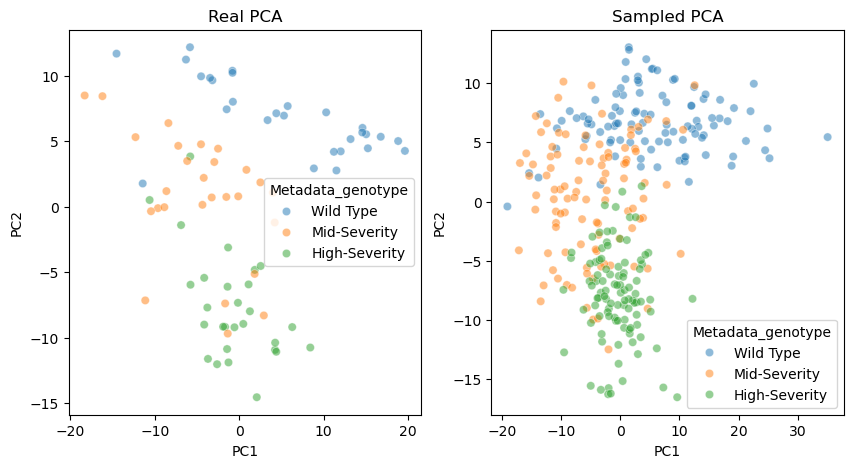

In [16]:
# annotate the genotypes of the sampled points
high_severity_sampled_points["Metadata_genotype"] = "High-Severity"
low_severity_sampled_points["Metadata_genotype"] = "Mid-Severity"
wt_sampled_points["Metadata_genotype"] = "Wild Type"
# concat the genotype sampled points
sampled_points = pd.concat(
    [wt_sampled_points, low_severity_sampled_points, high_severity_sampled_points]
)

# plot the first 2 PCA components from the actual data
# set up subplots
plt.figure(figsize=(10, 5))
# subplot 1
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=custom_aggregated_data_pca,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Real PCA")

# plot the first 2 PCA components from the sampled data
# subplot 2
plt.subplot(1, 2, 2)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sampled_points,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Sampled PCA")
plt.show()